# CloudSplaining in AWS Managed Policies (camp)

## Load CSV file into a Panda

In [33]:
import pandas as pd
import datetime

pd = pd.read_csv('data/versions_summary.csv')
pd['CreateDate'] = pd['CreateDate'].apply(lambda x: datetime.datetime.fromisoformat(x))
pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   PolicyName                  2031 non-null   object             
 1   VersionId                   2031 non-null   object             
 2   IsDefaultVersion            2031 non-null   bool               
 3   CreateDate                  2031 non-null   datetime64[ns, UTC]
 4   ServiceWildcard             2031 non-null   int64              
 5   ServicesAffected            2031 non-null   int64              
 6   PrivilegeEscalation         2031 non-null   int64              
 7   ResourceExposure            2031 non-null   int64              
 8   DataExfiltration            2031 non-null   int64              
 9   CredentialsExposure         2031 non-null   int64              
 10  InfrastructureModification  2031 non-null   int64           

# Plot Version History

This will ignore polices for which no interesting findings exist, or those with a single version.

/Users/asieira/.virtualenvs/camp/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


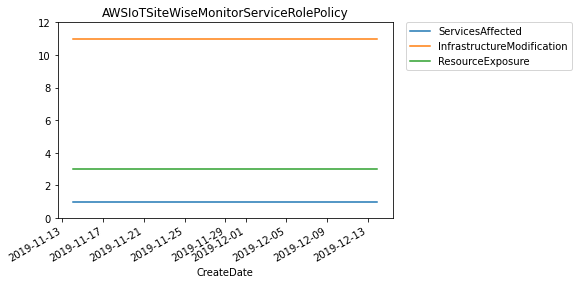

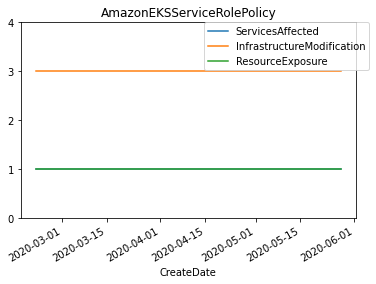

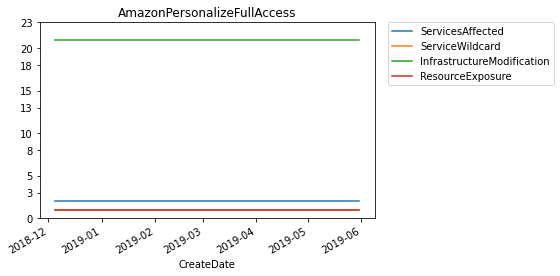

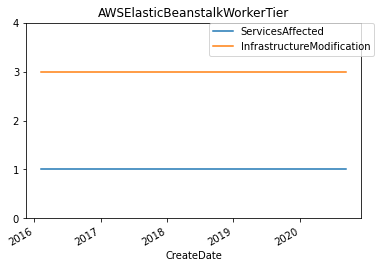

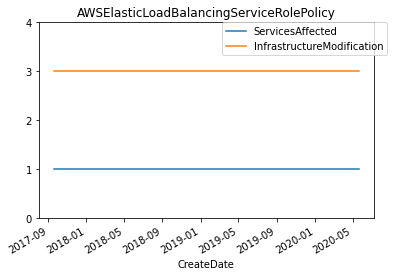

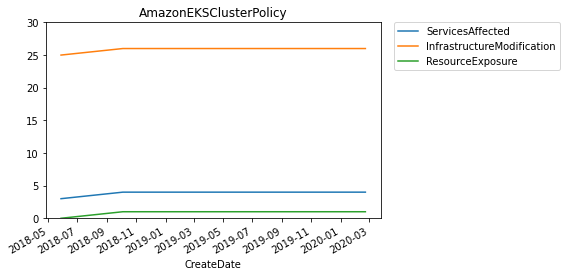

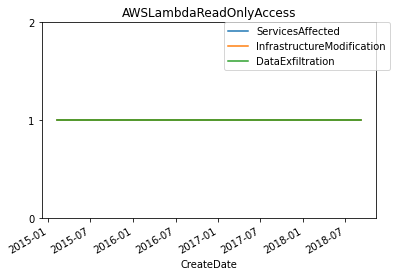

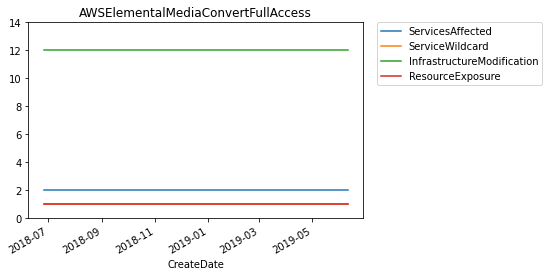

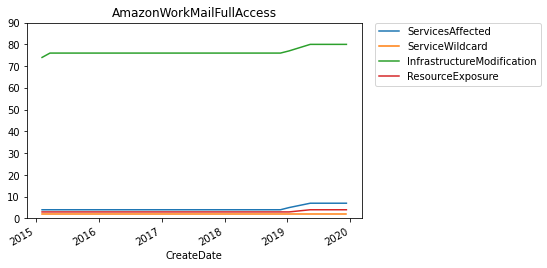

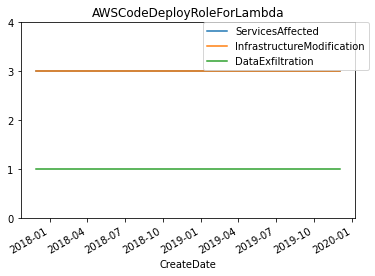

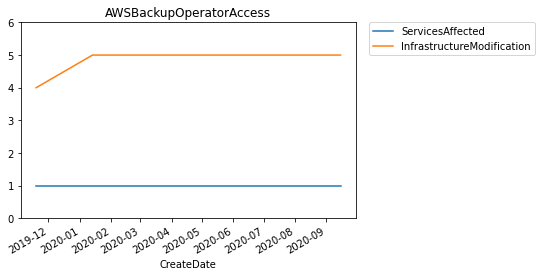

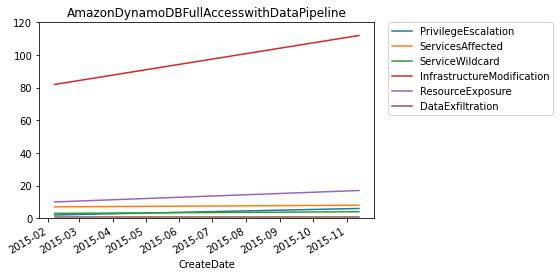

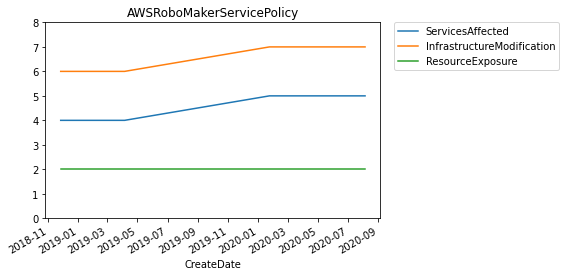

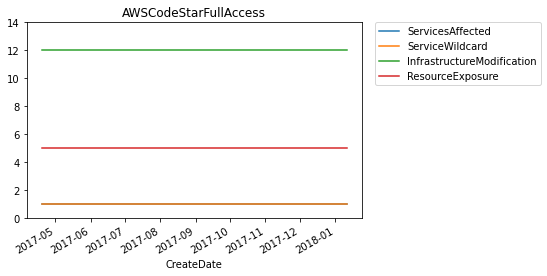

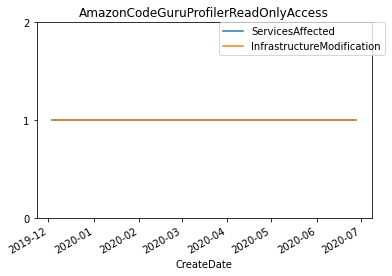

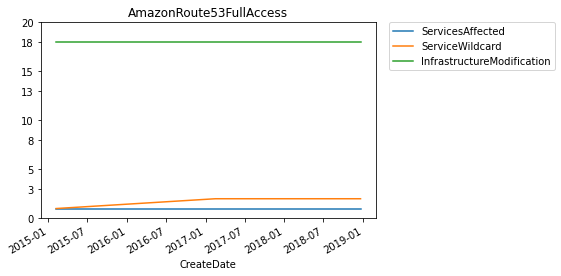

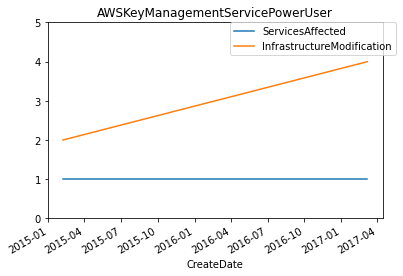

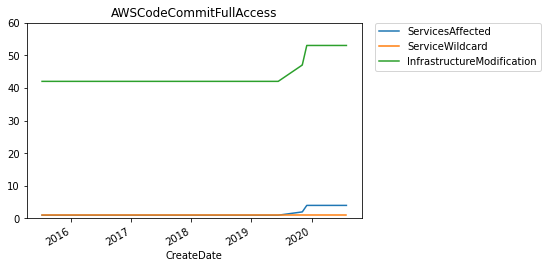

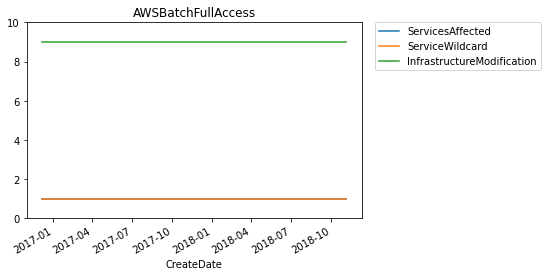

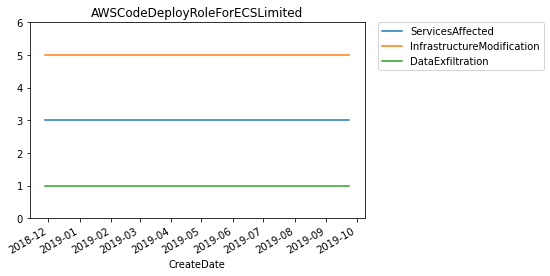

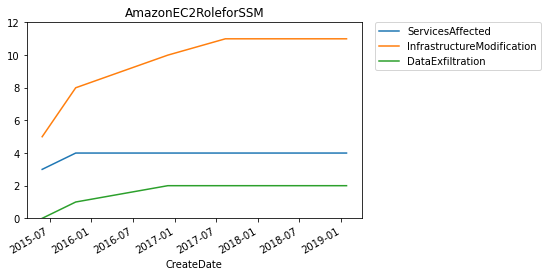

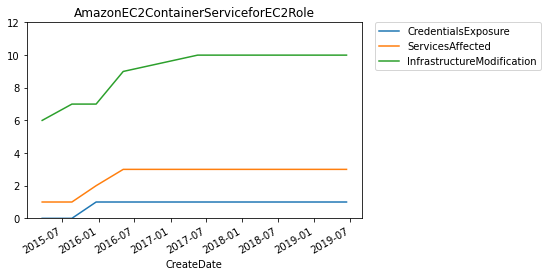

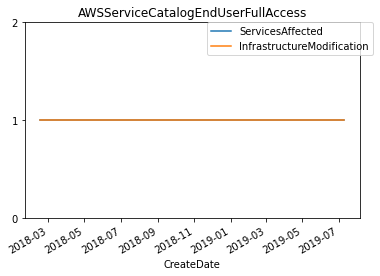

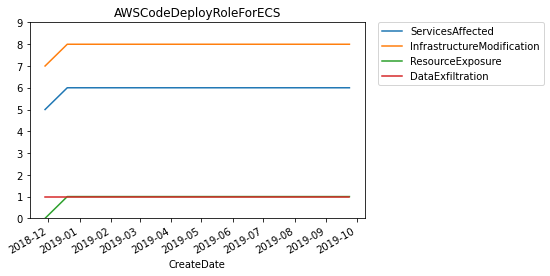

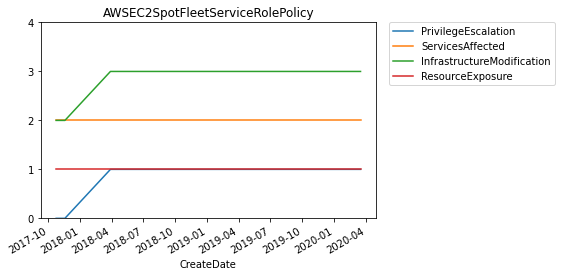

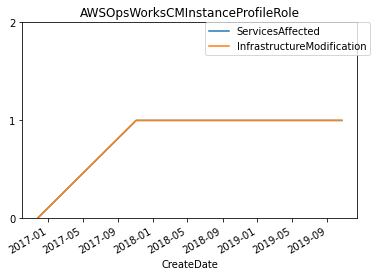

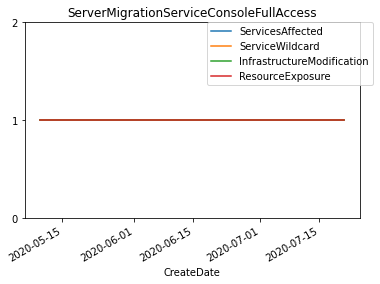

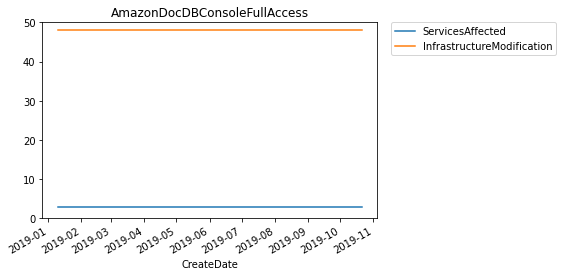

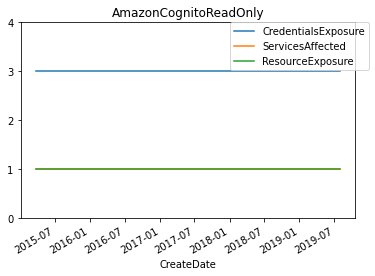

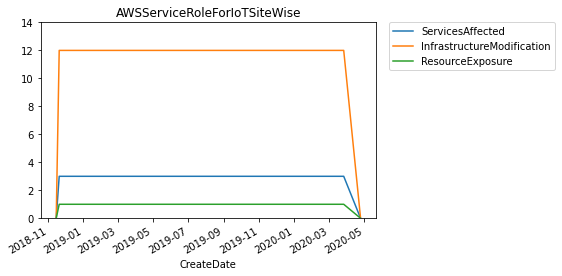

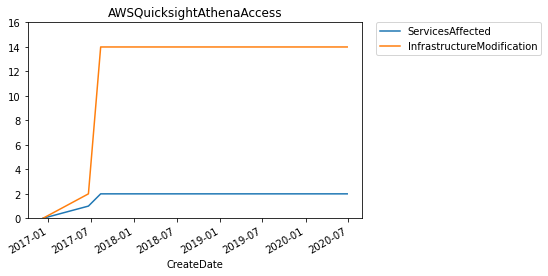

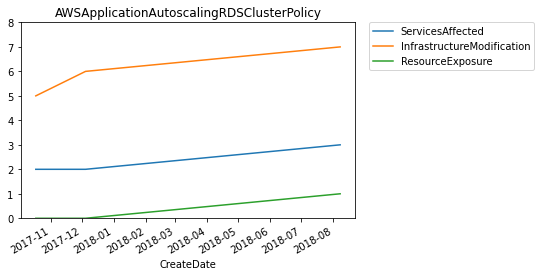

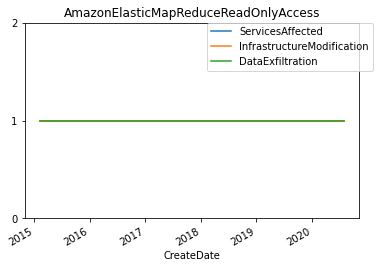

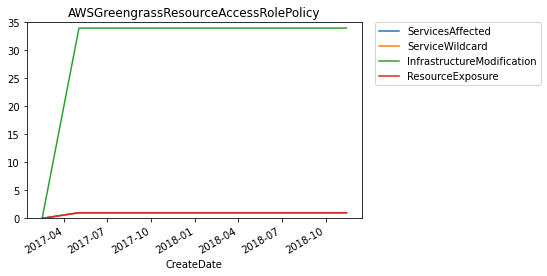

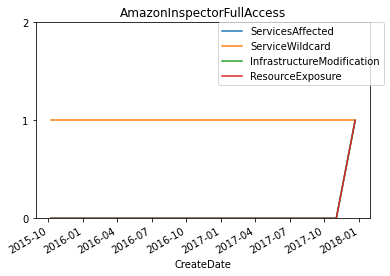

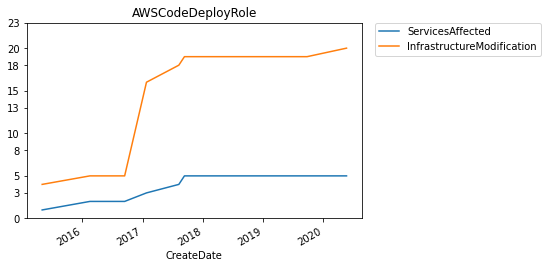

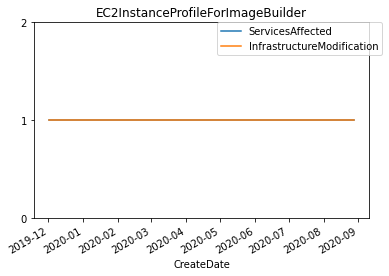

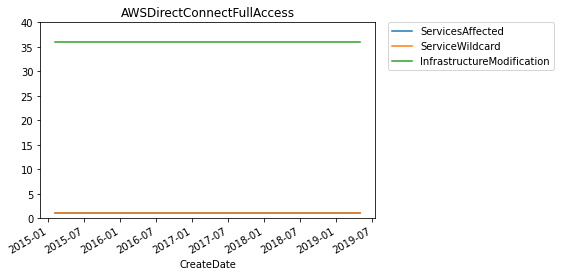

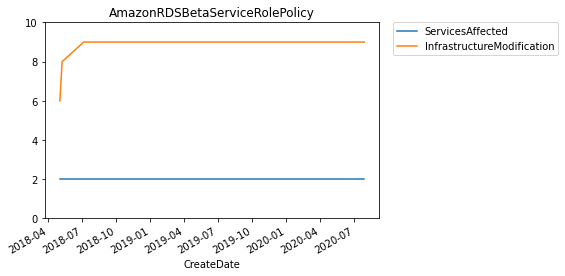

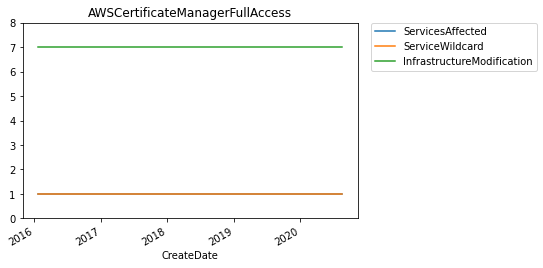

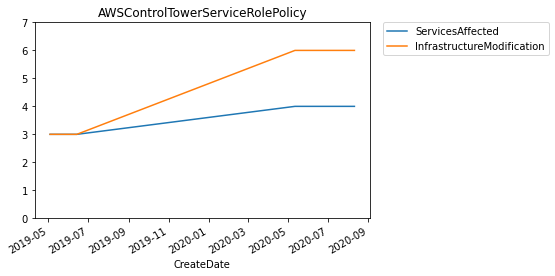

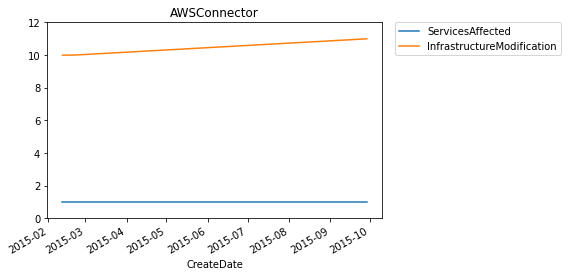

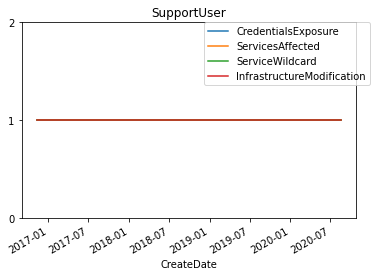

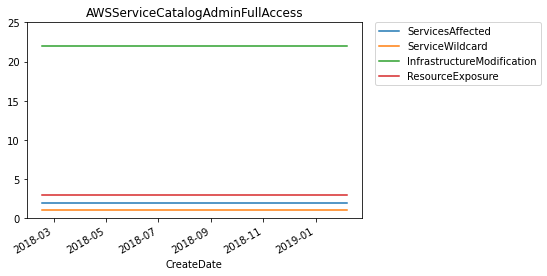

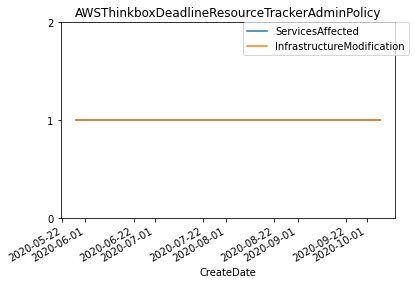

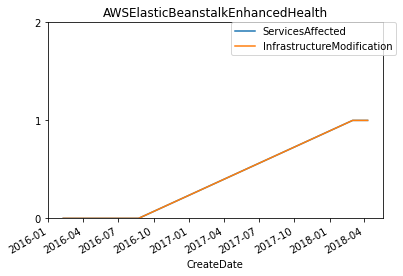

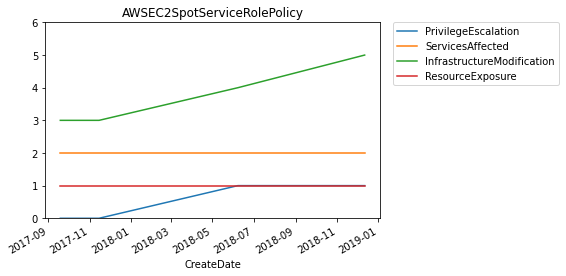

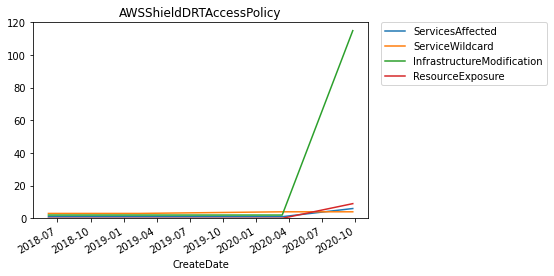

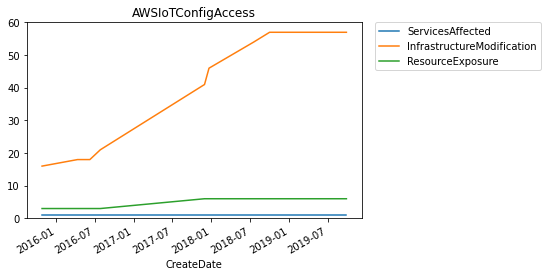

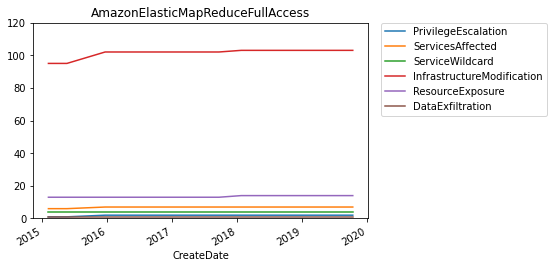

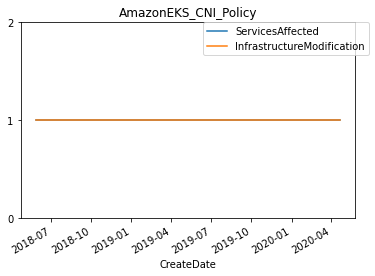

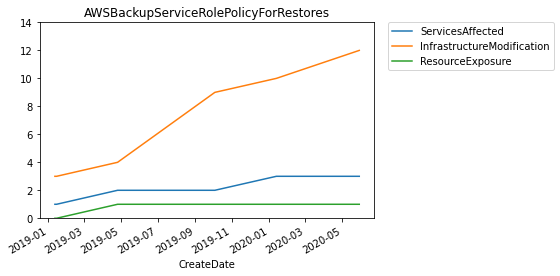

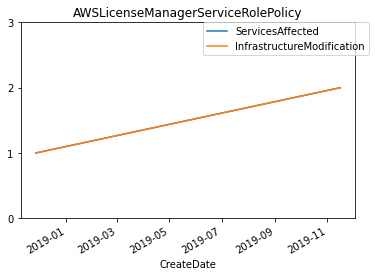

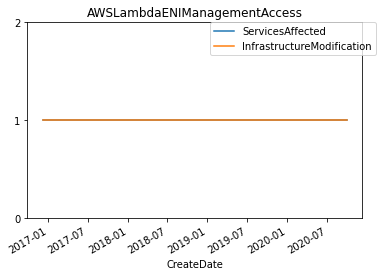

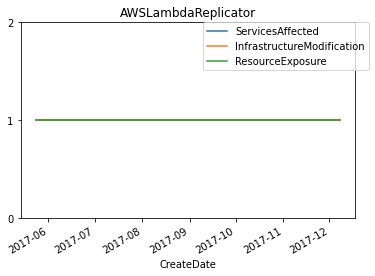

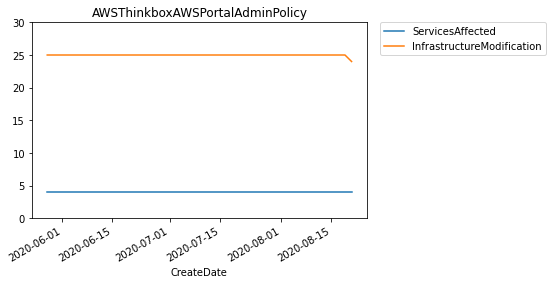

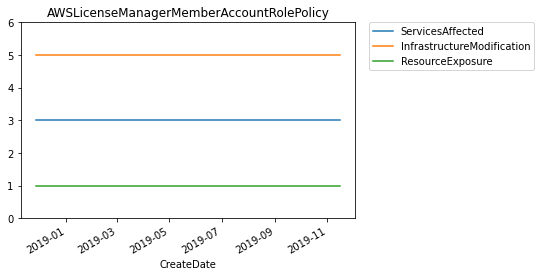

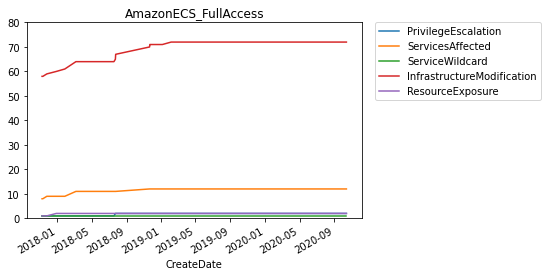

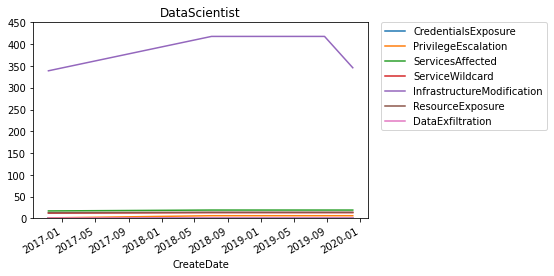

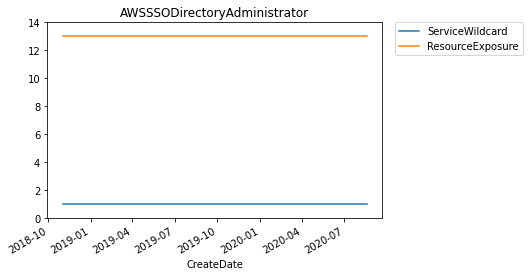

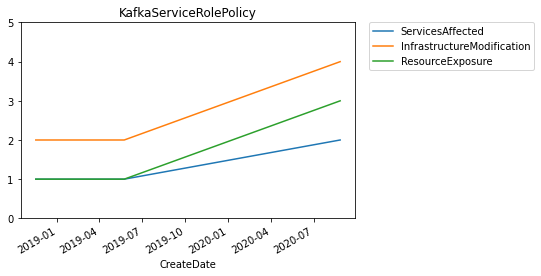

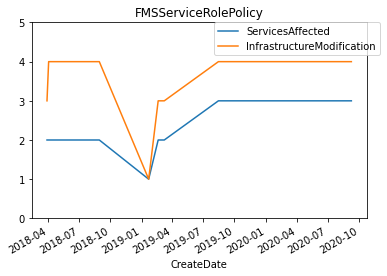

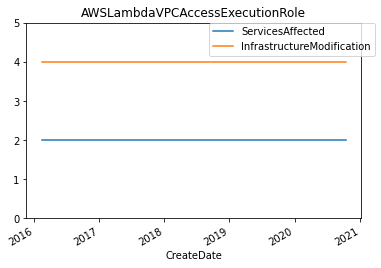

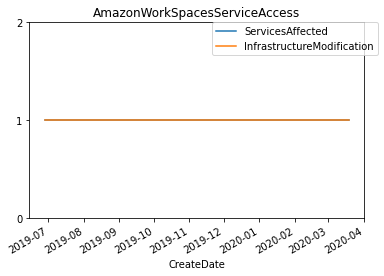

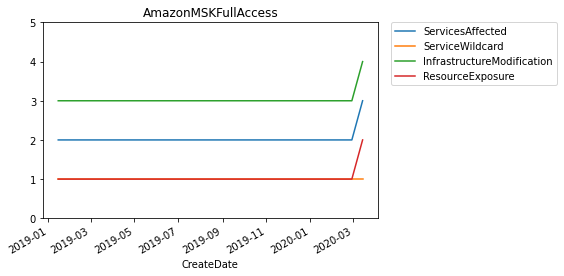

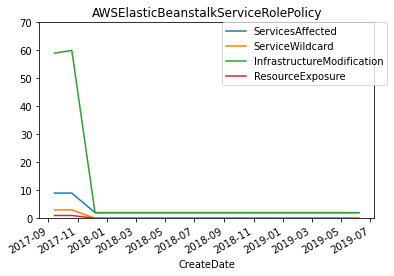

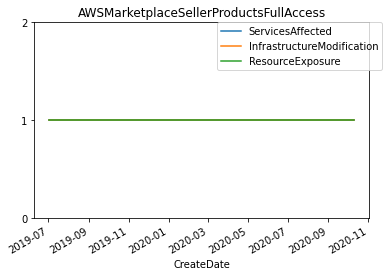

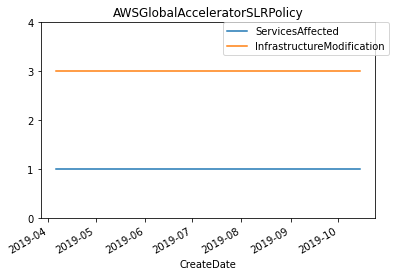

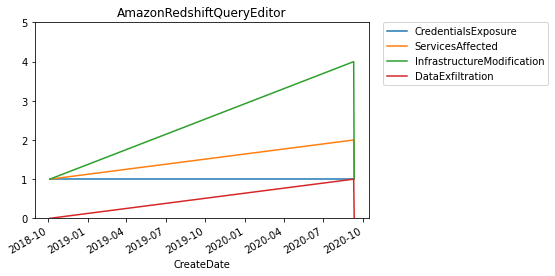

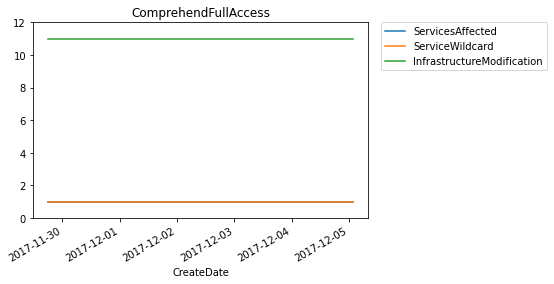

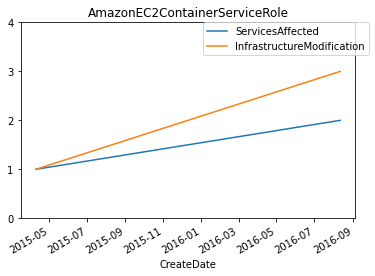

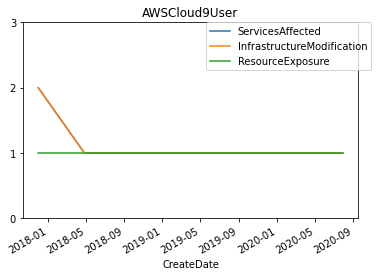

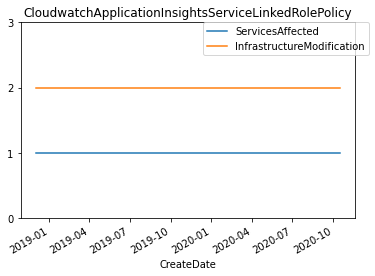

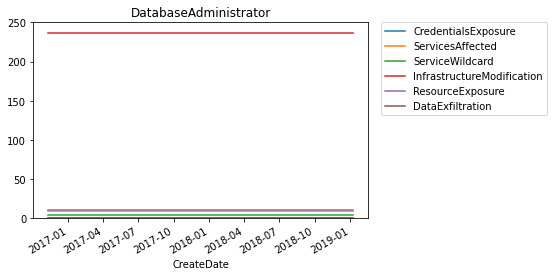

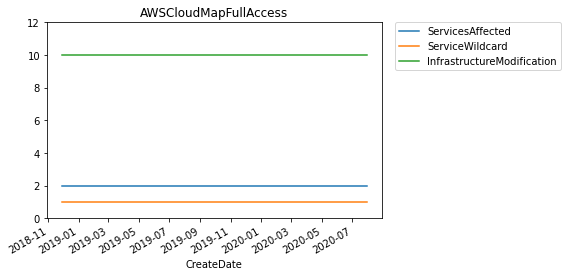

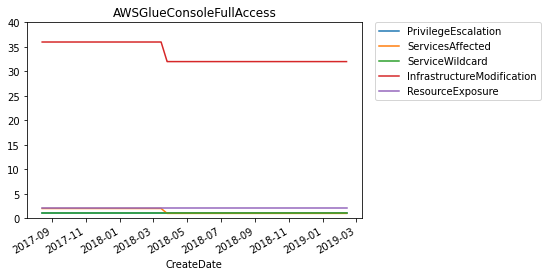

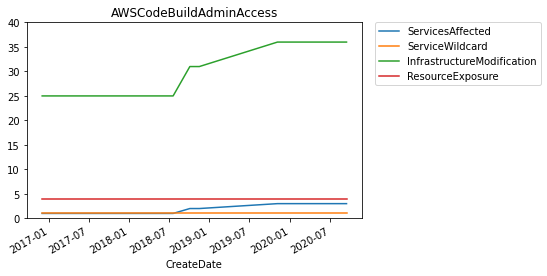

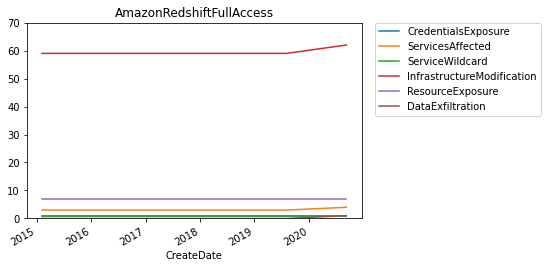

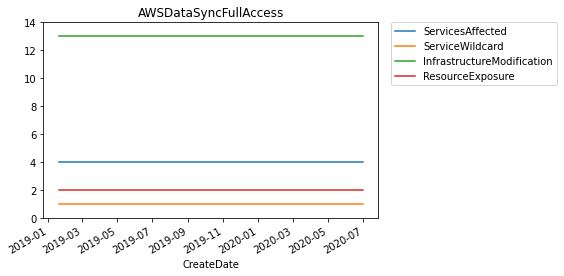

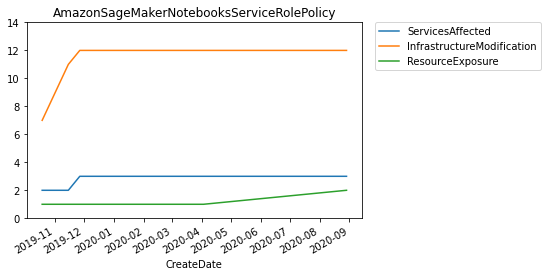

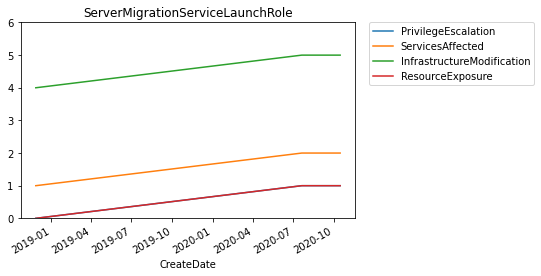

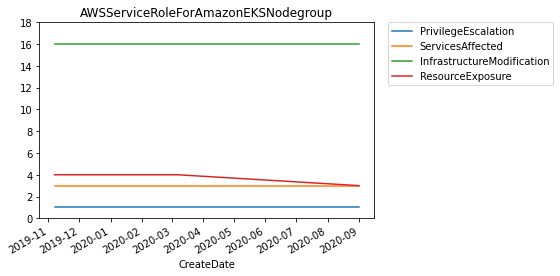

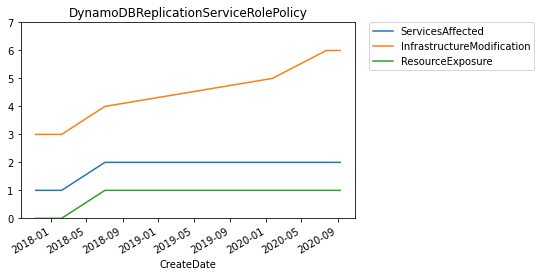

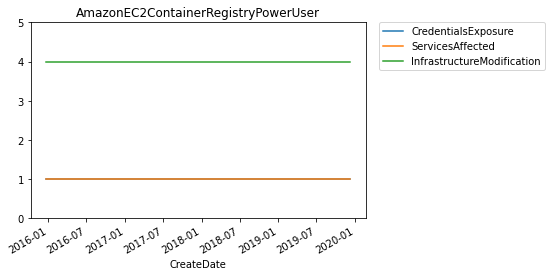

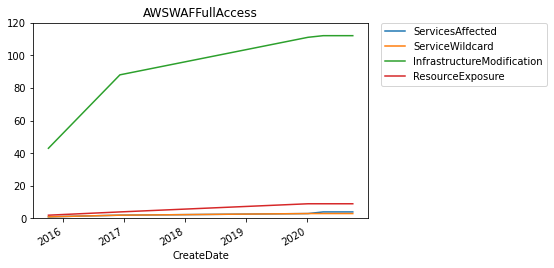

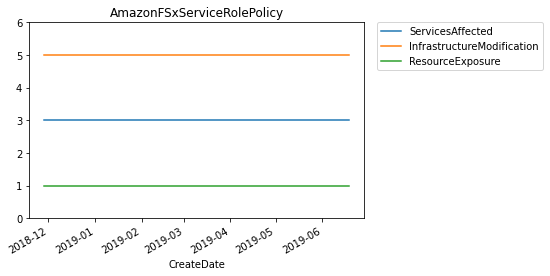

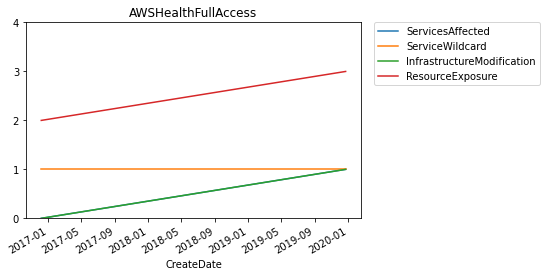

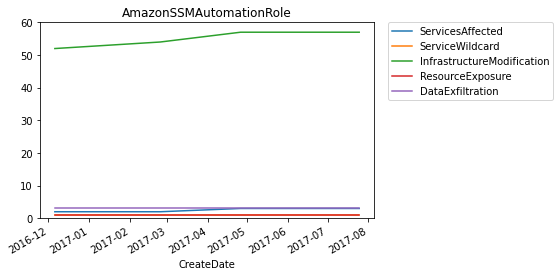

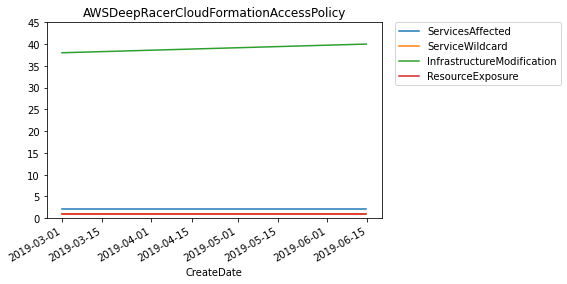

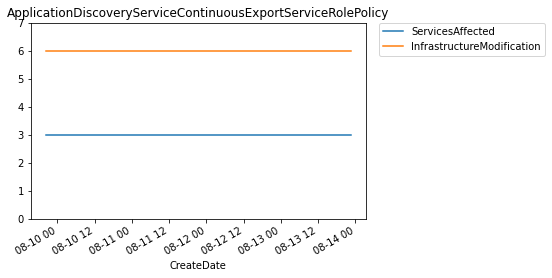

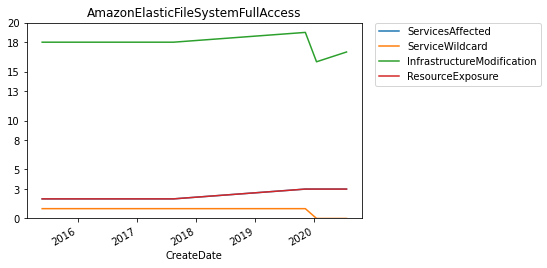

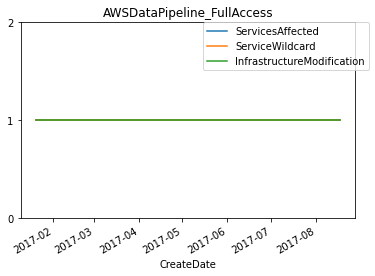

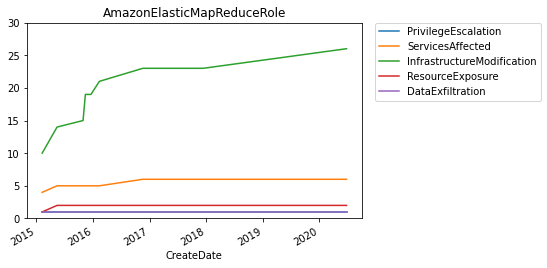

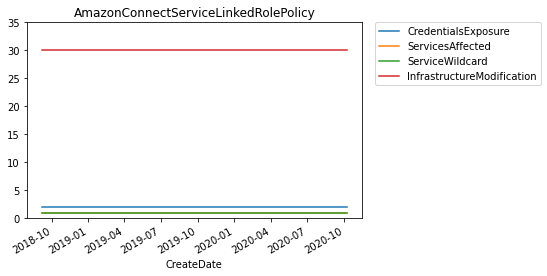

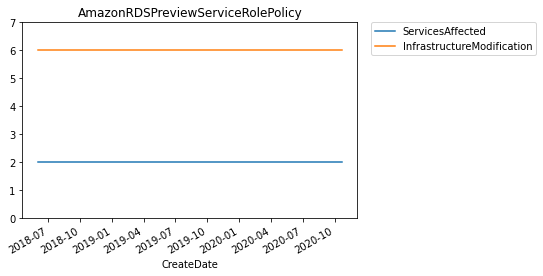

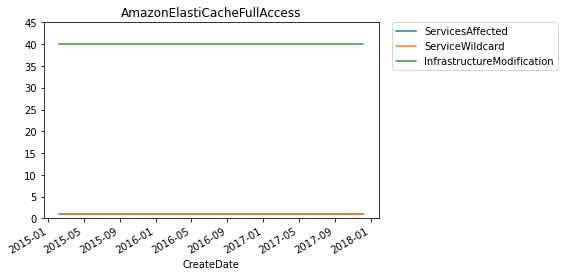

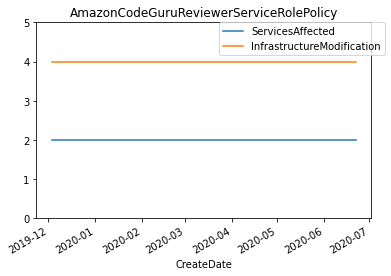

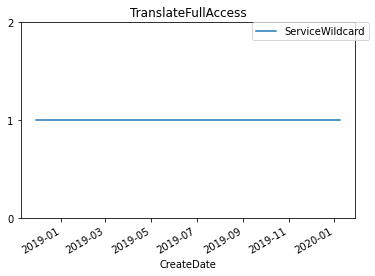

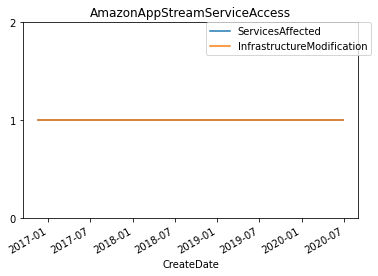

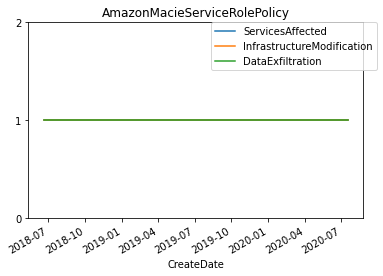

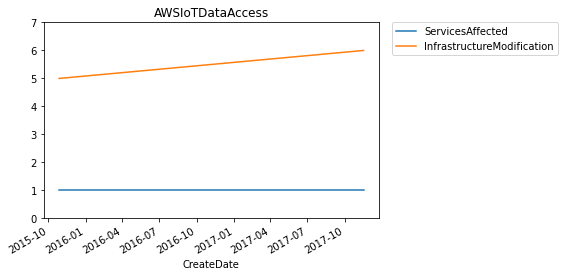

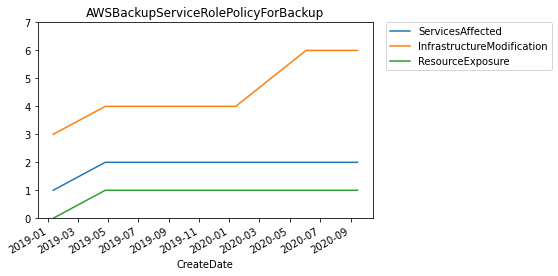

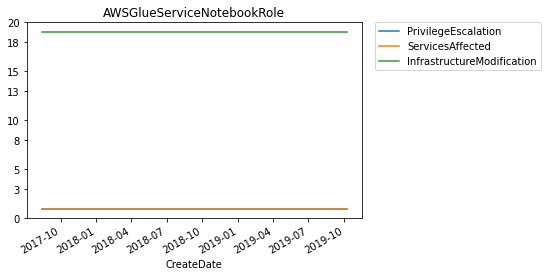

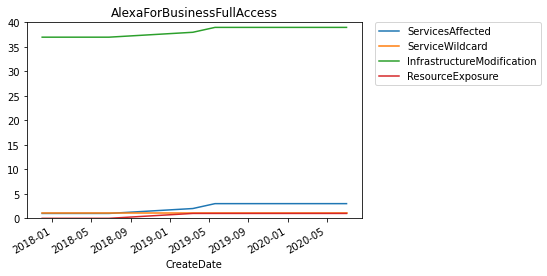

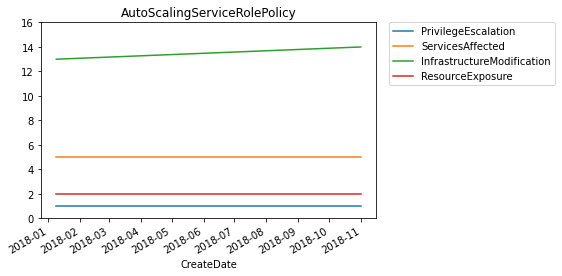

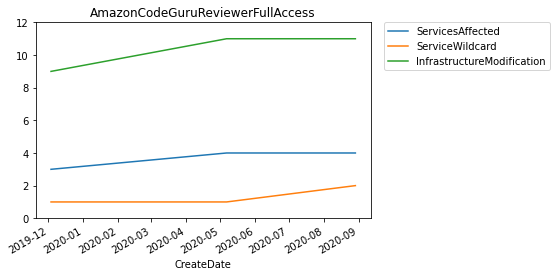

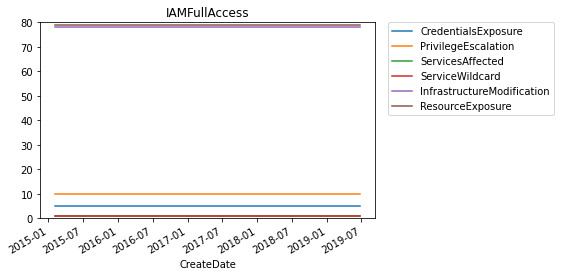

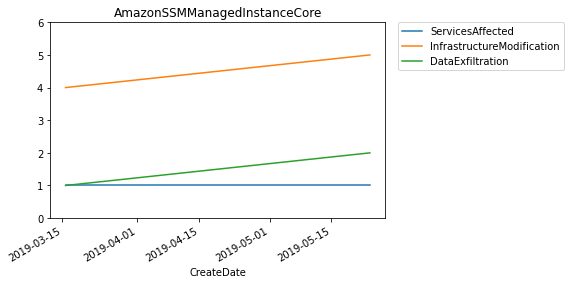

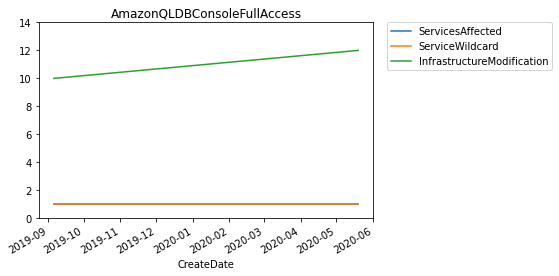

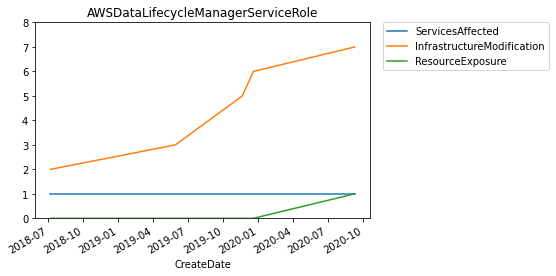

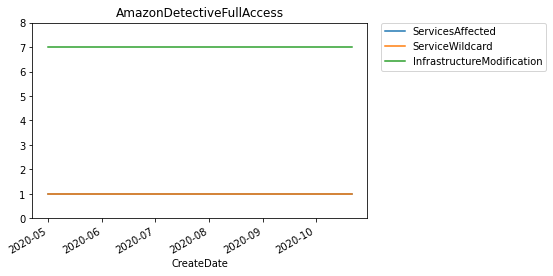

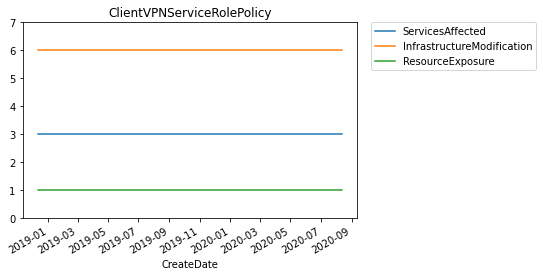

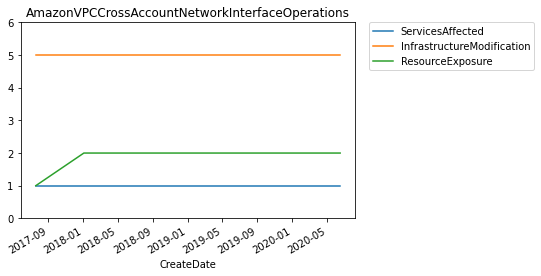

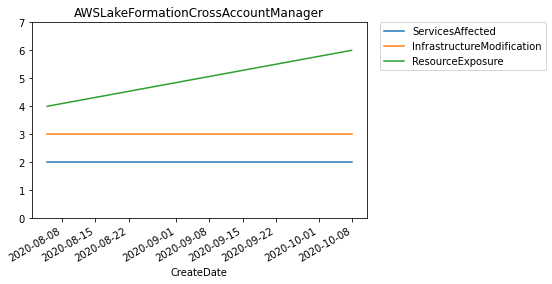

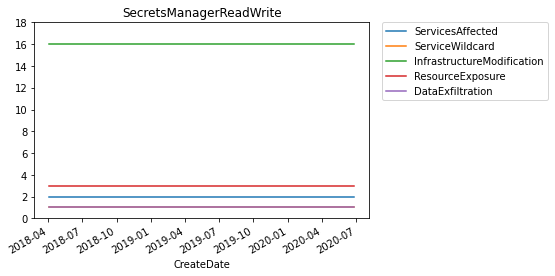

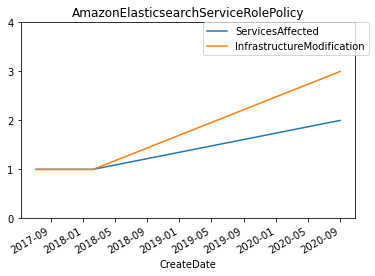

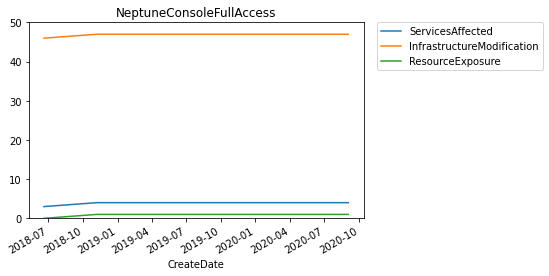

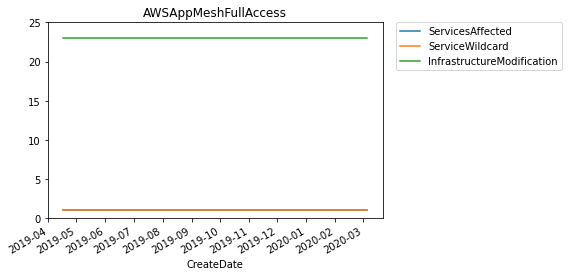

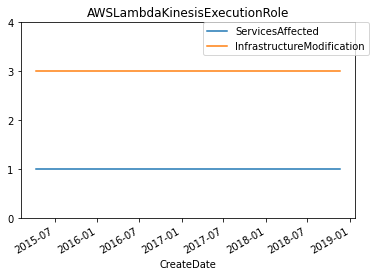

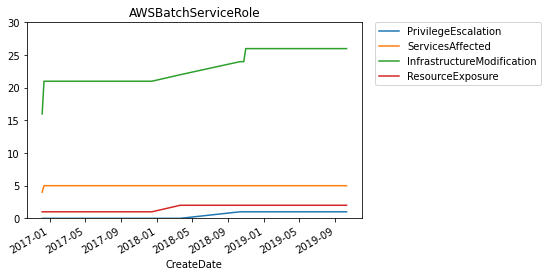

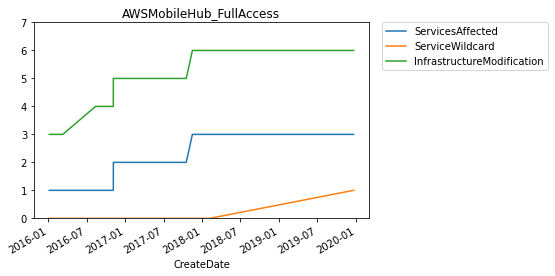

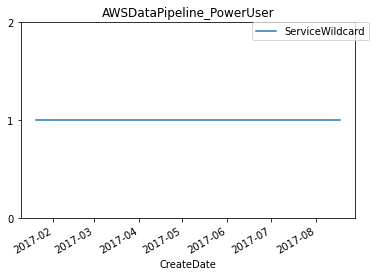

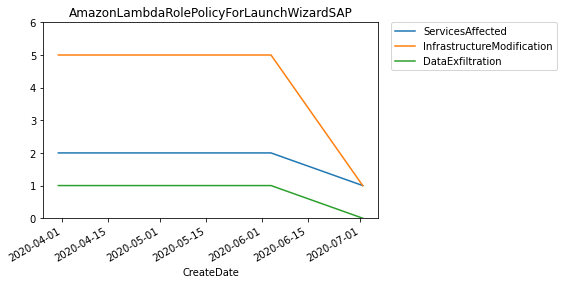

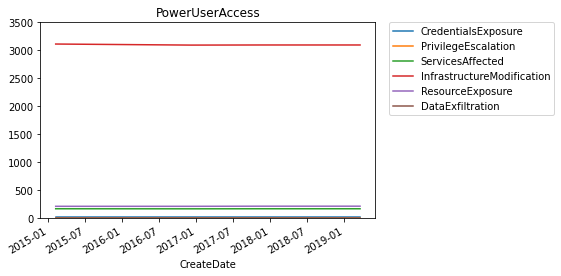

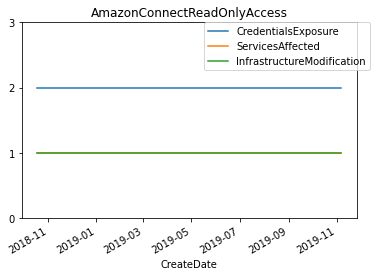

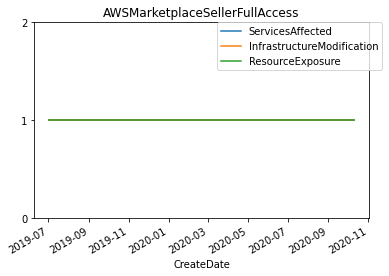

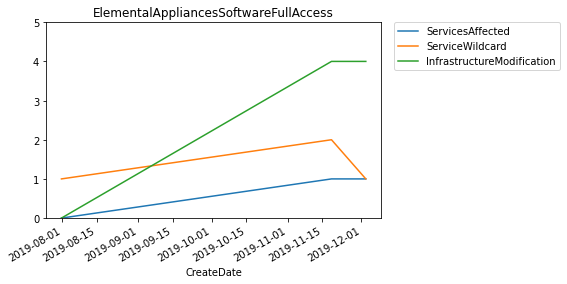

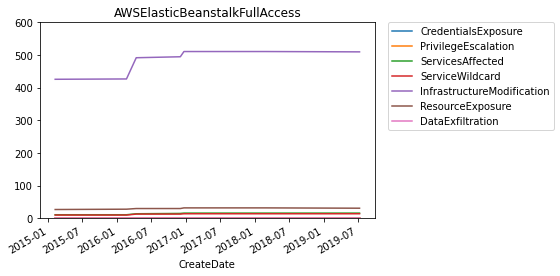

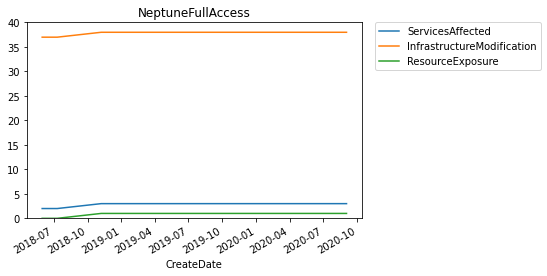

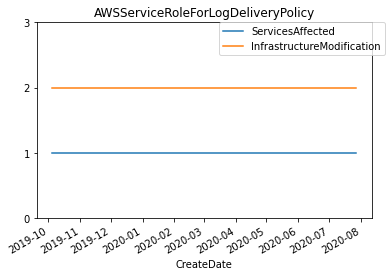

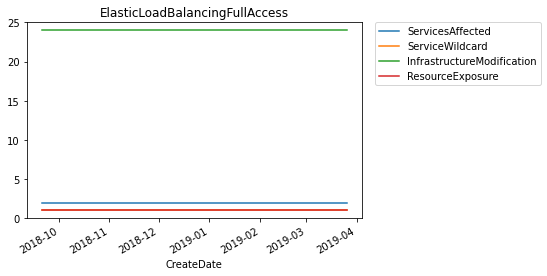

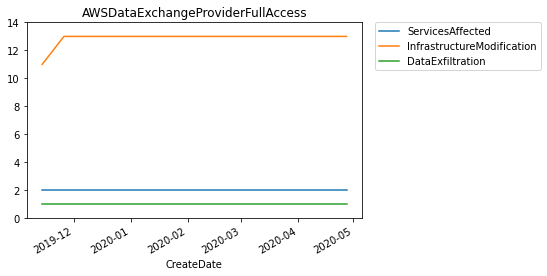

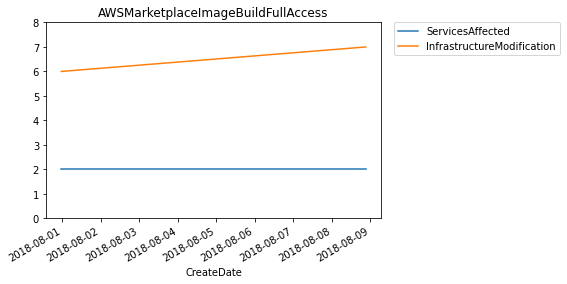

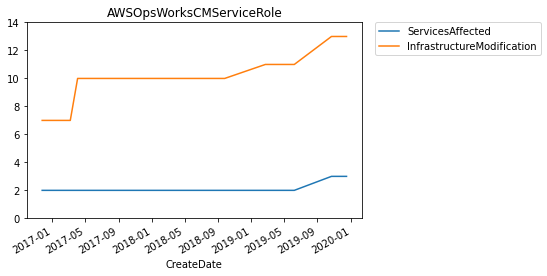

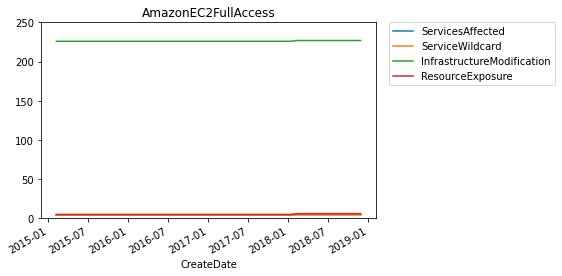

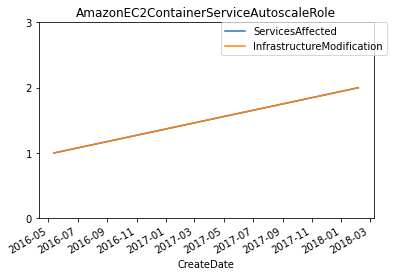

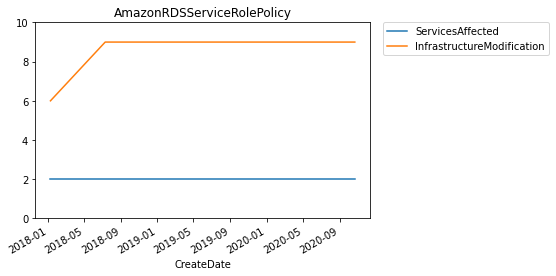

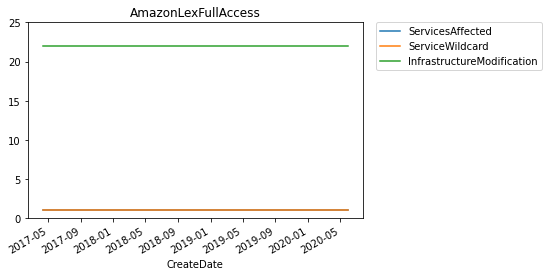

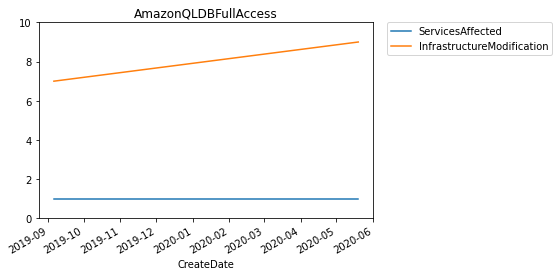

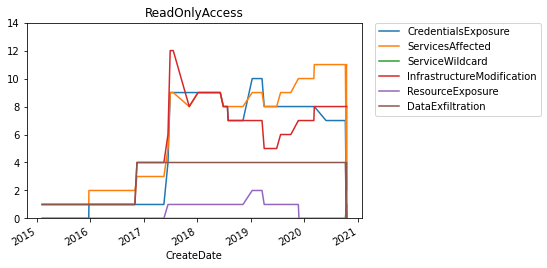

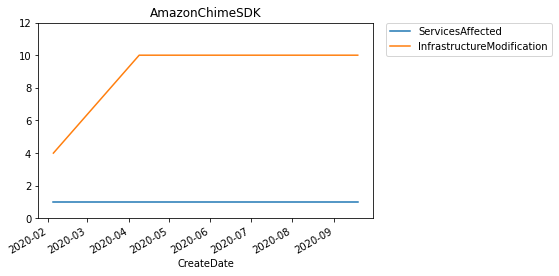

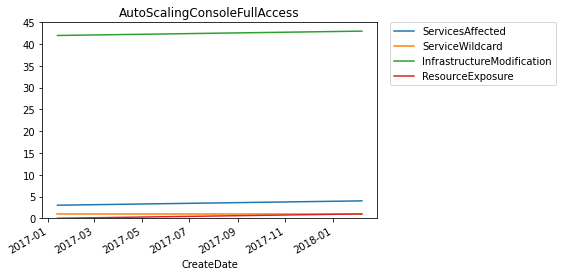

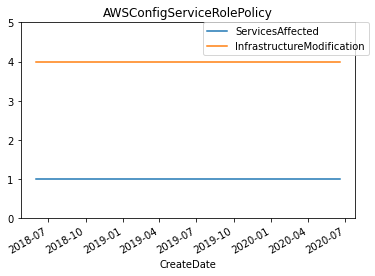

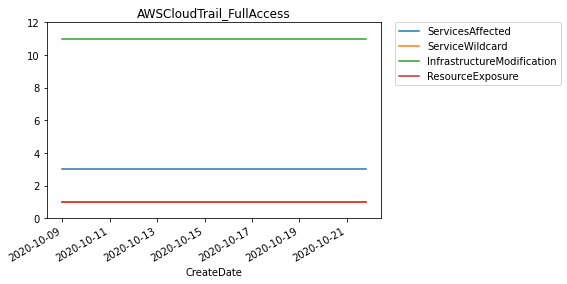

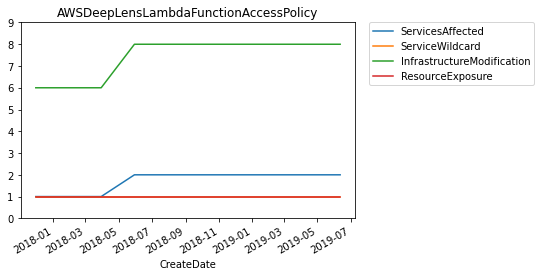

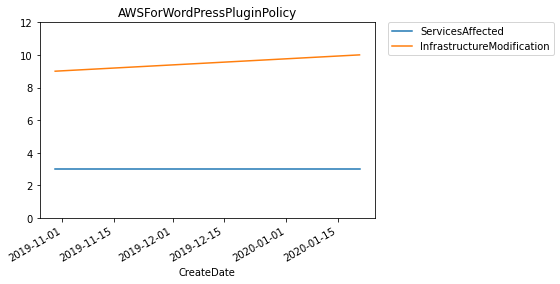

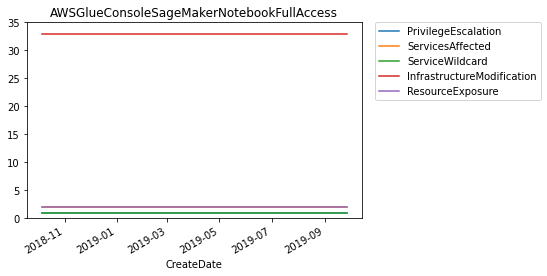

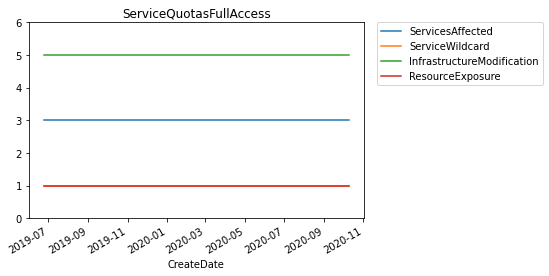

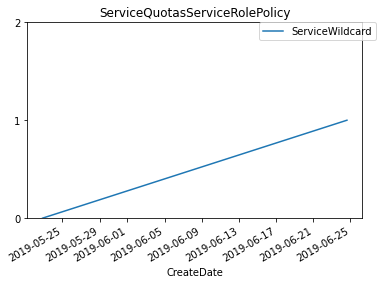

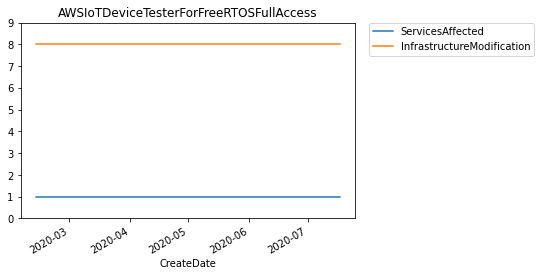

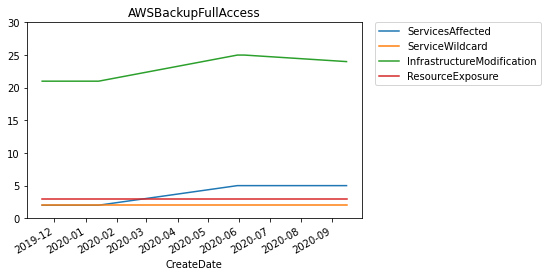

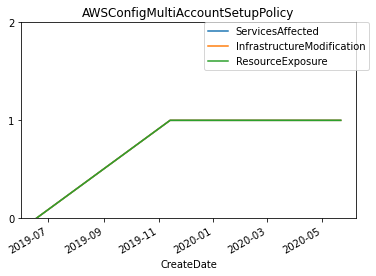

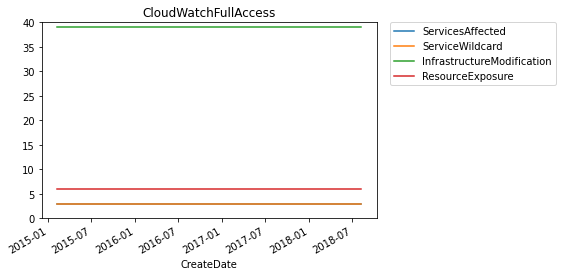

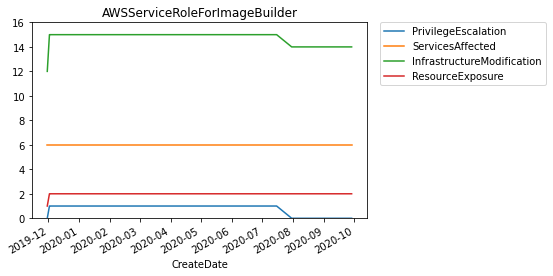

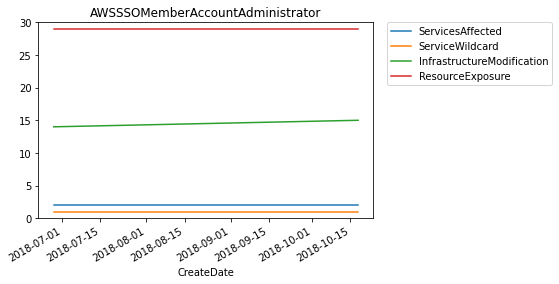

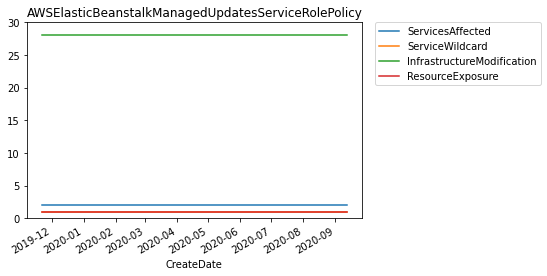

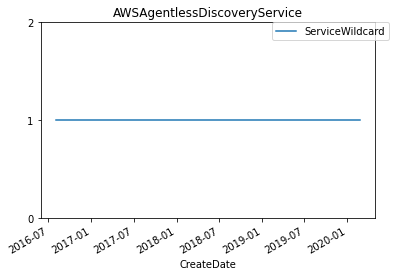

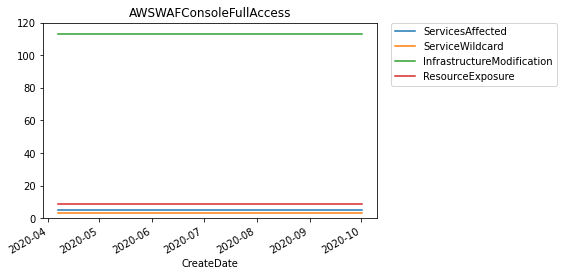

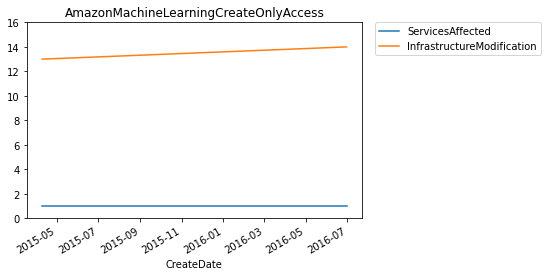

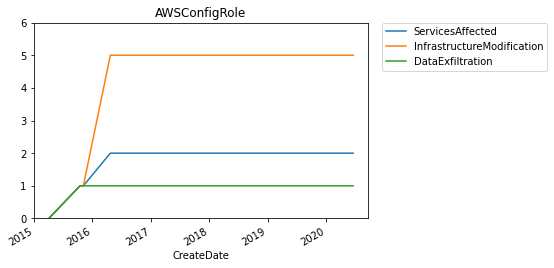

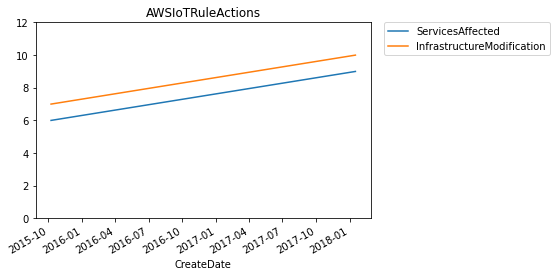

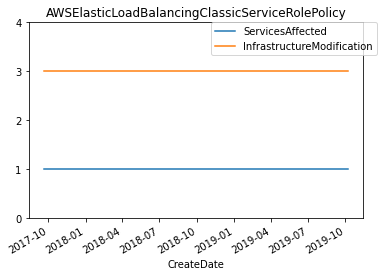

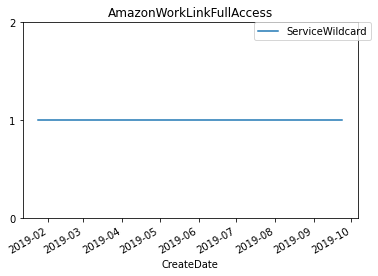

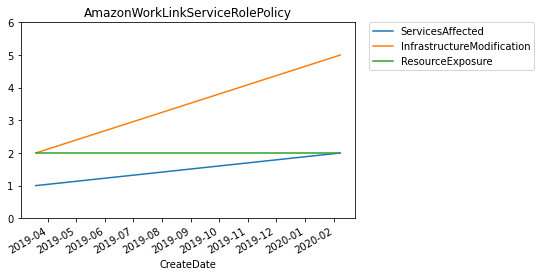

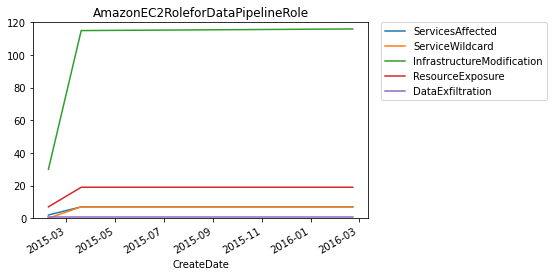

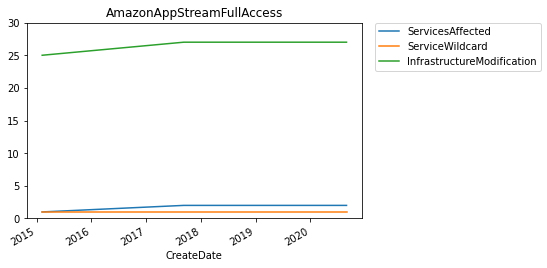

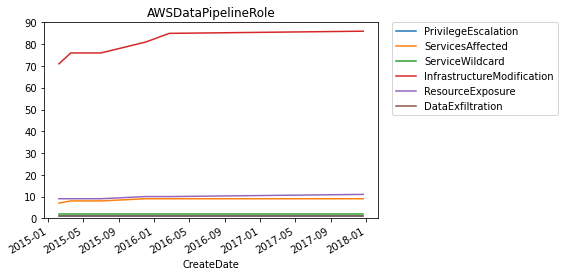

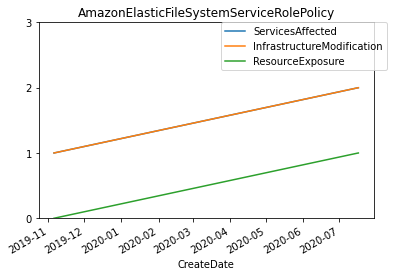

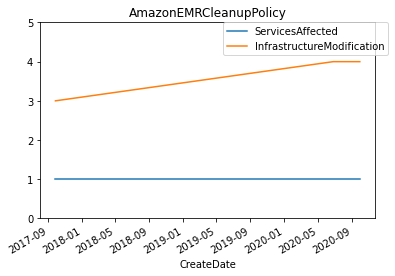

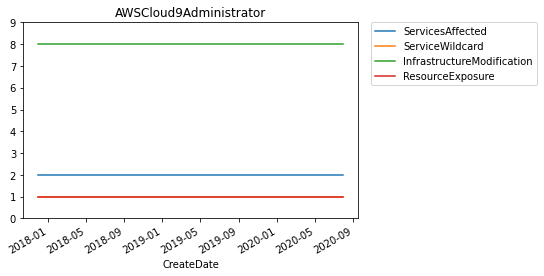

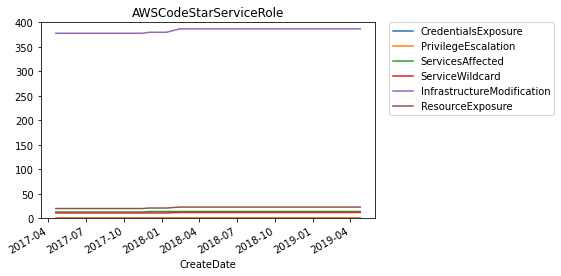

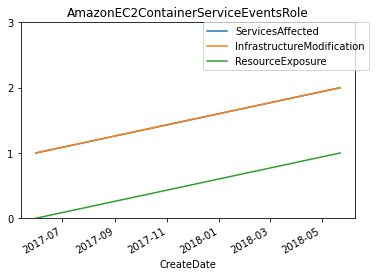

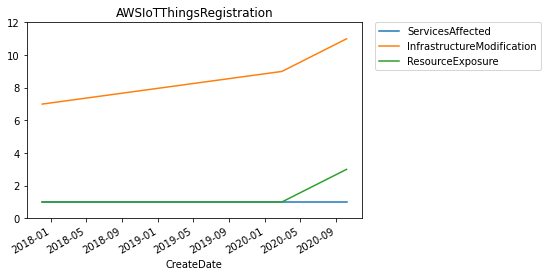

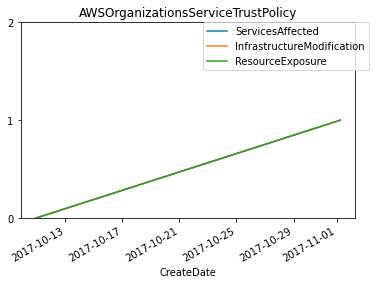

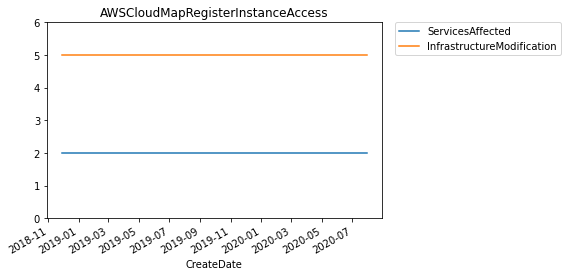

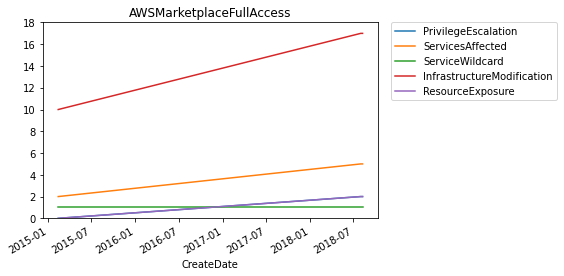

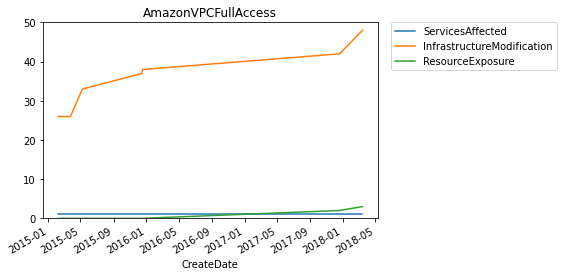

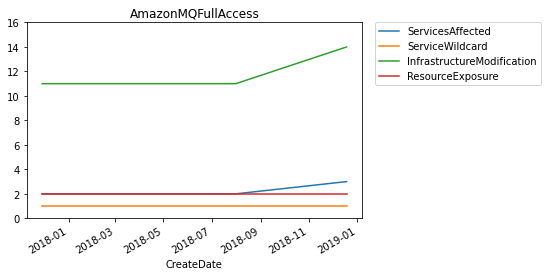

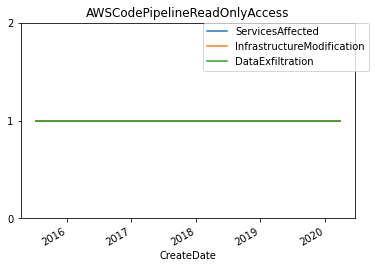

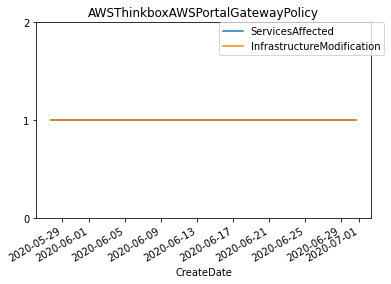

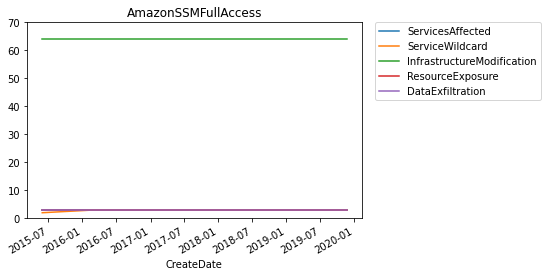

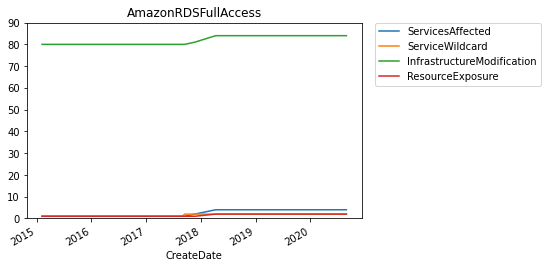

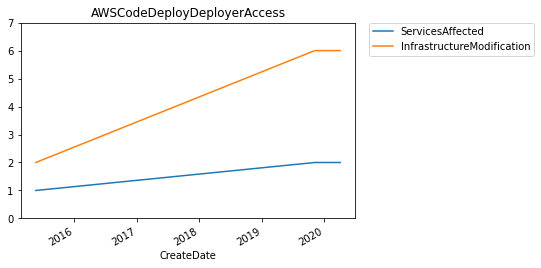

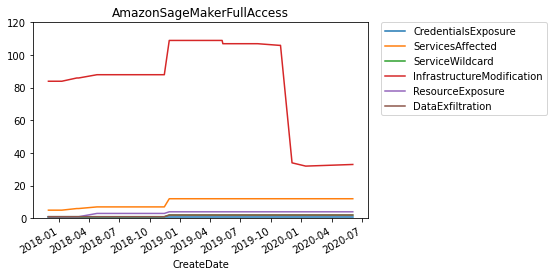

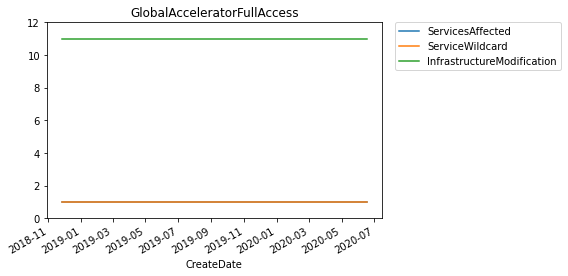

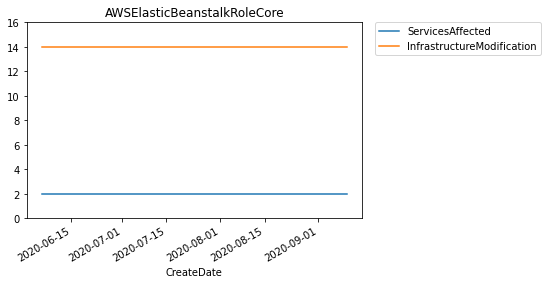

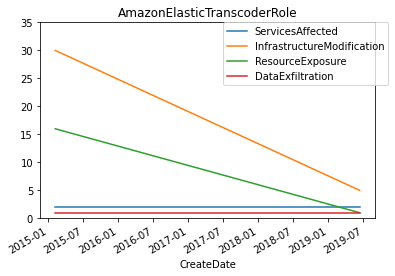

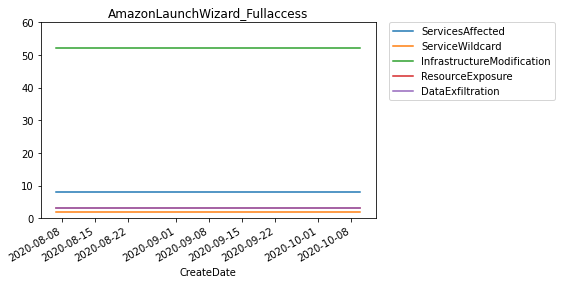

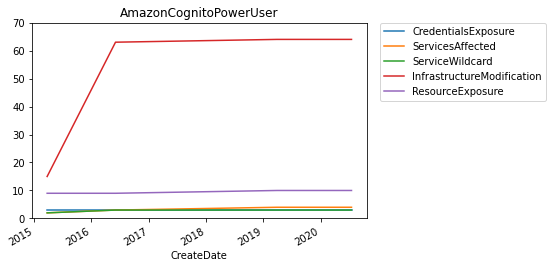

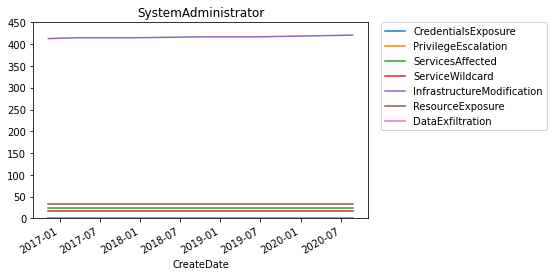

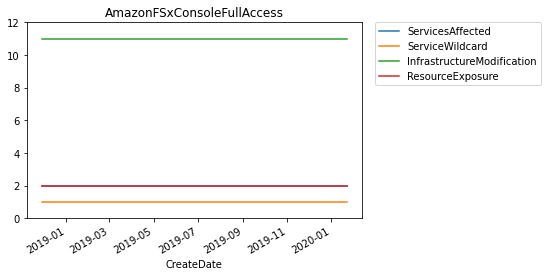

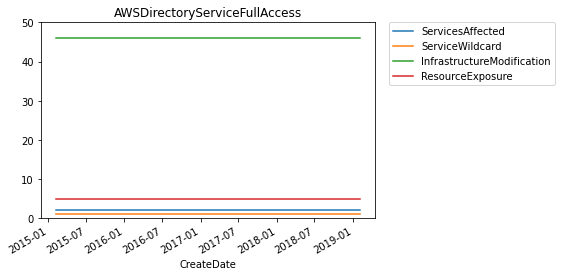

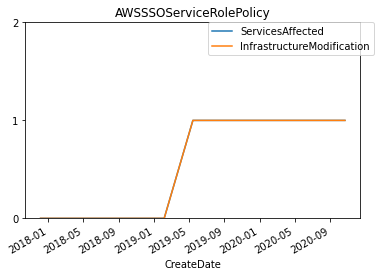

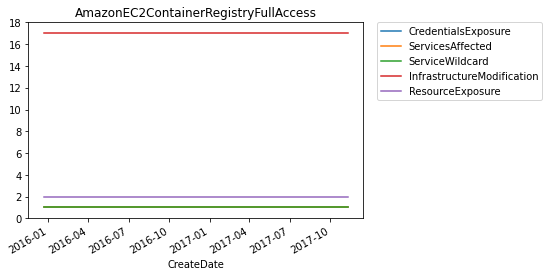

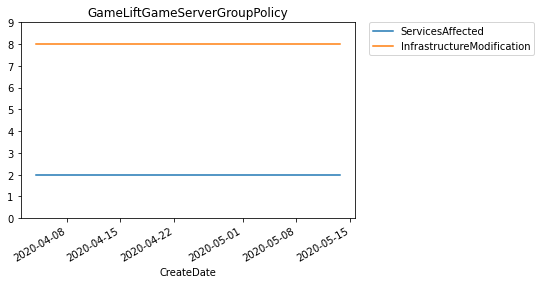

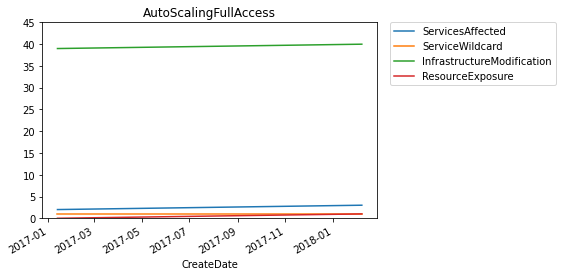

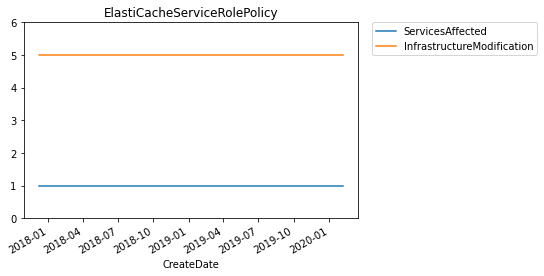

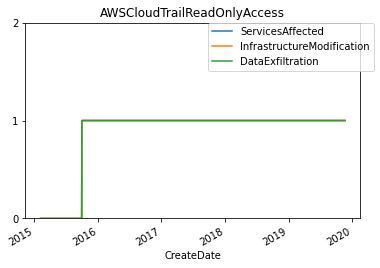

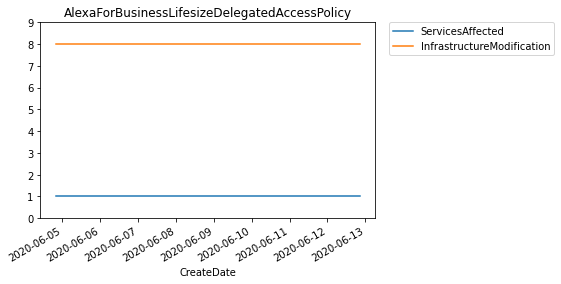

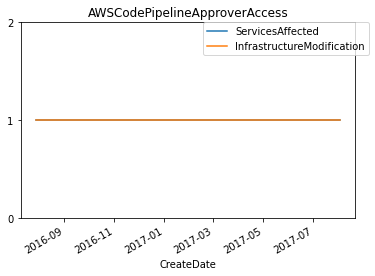

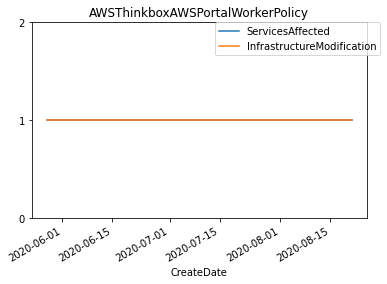

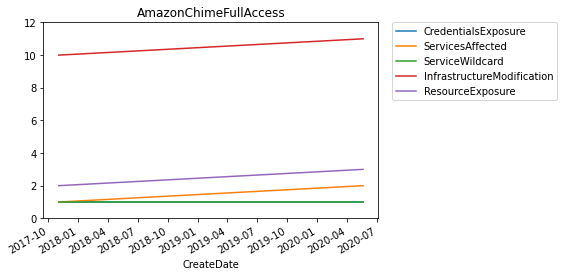

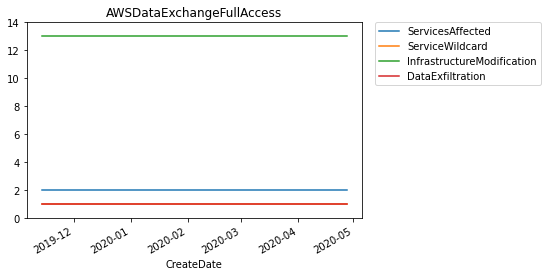

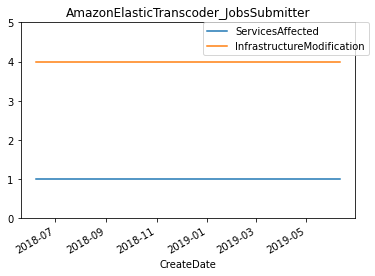

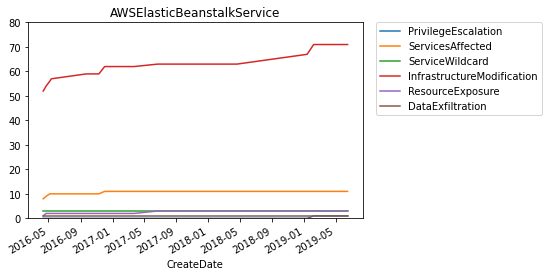

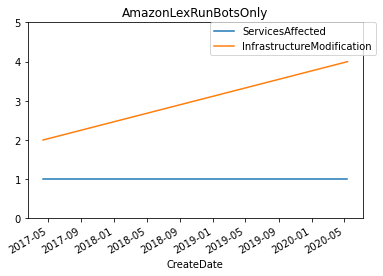

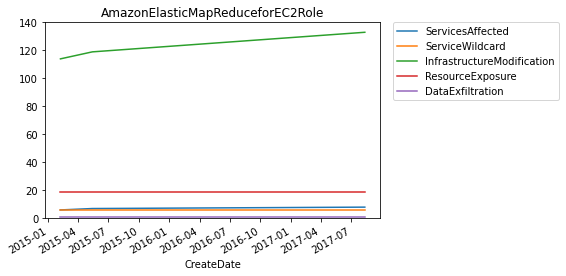

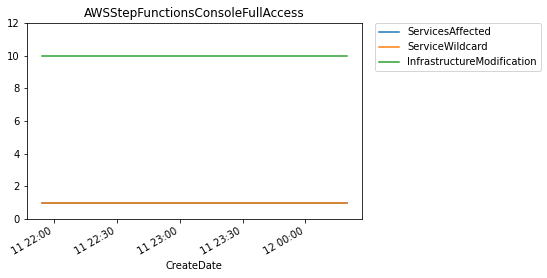

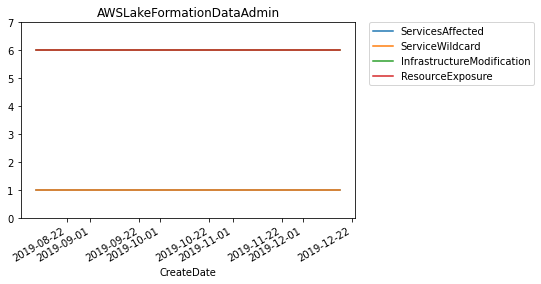

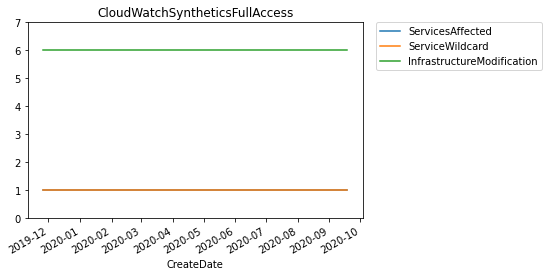

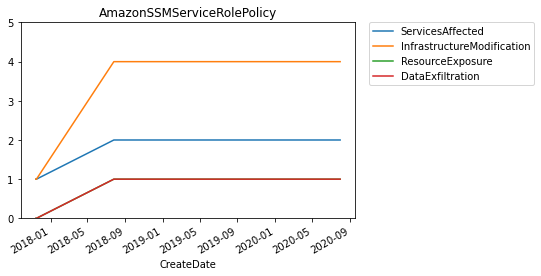

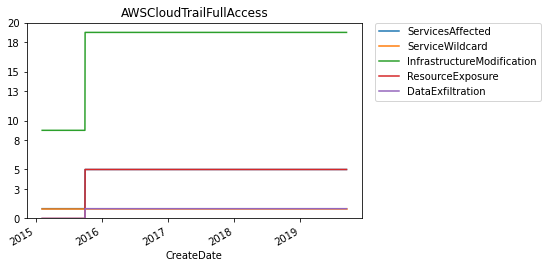

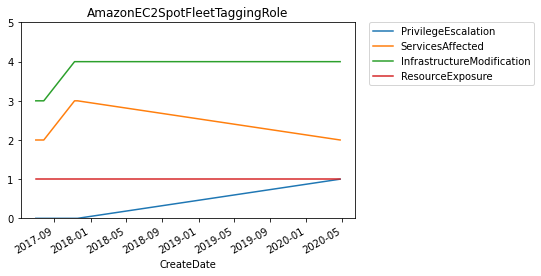

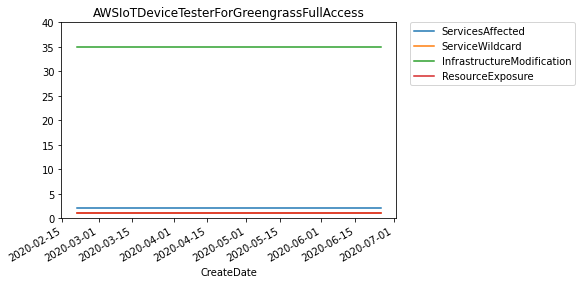

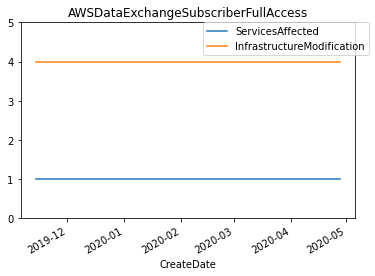

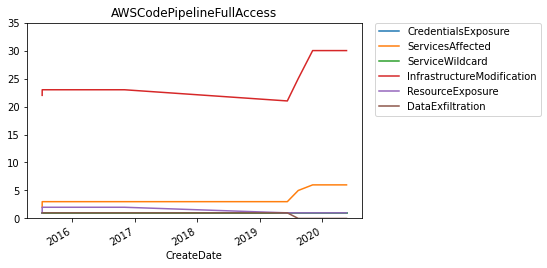

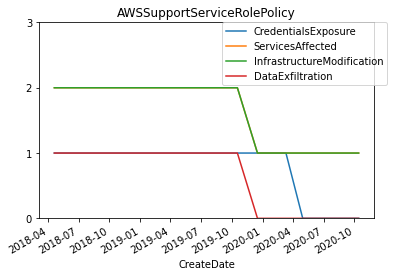

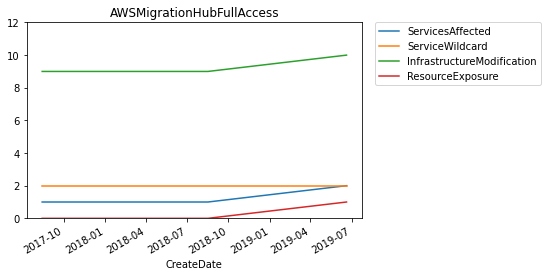

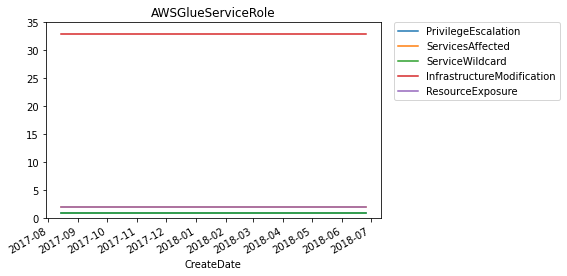

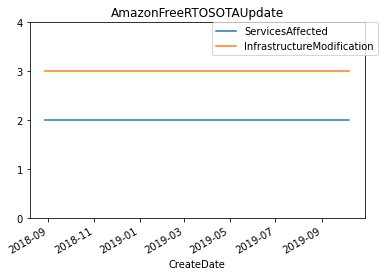

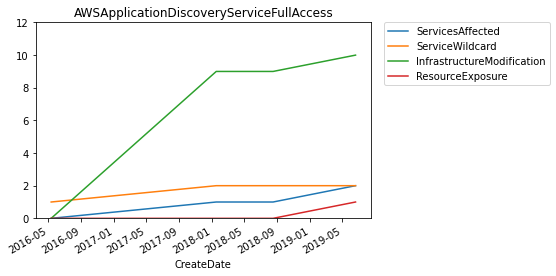

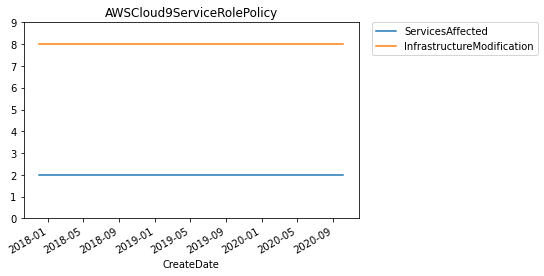

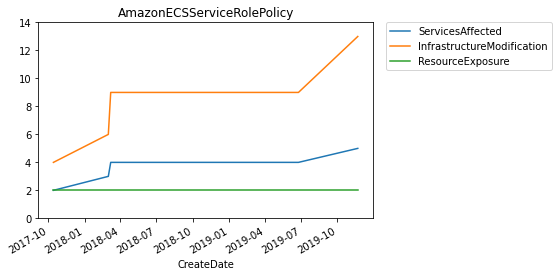

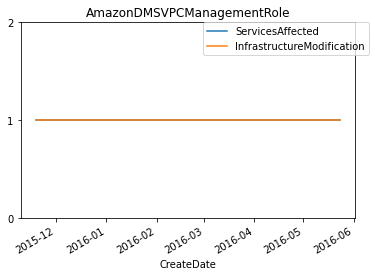

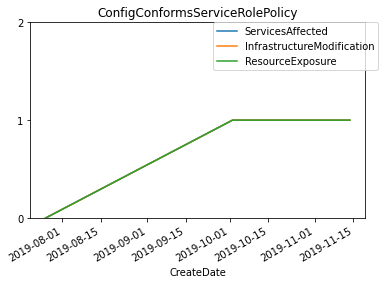

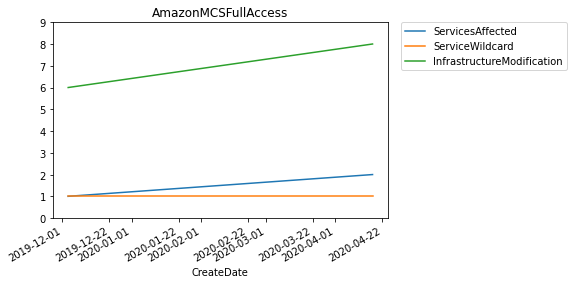

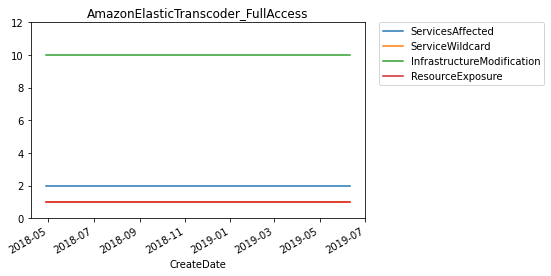

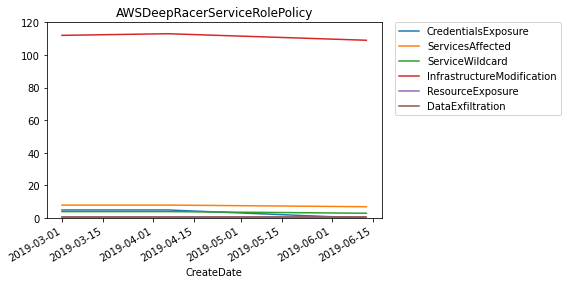

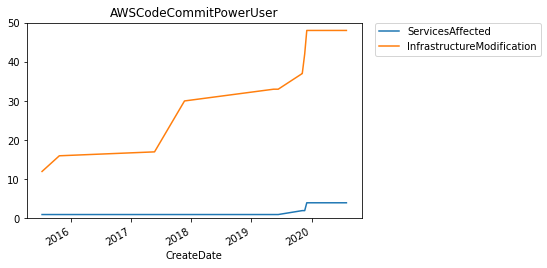

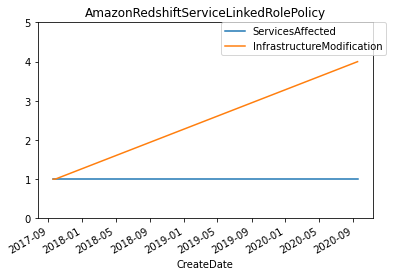

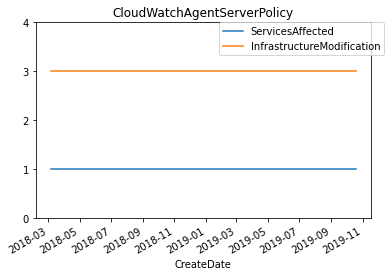

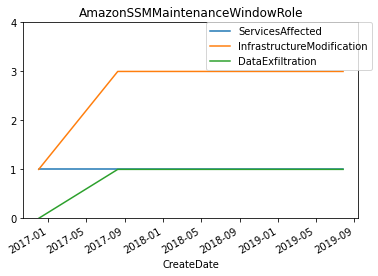

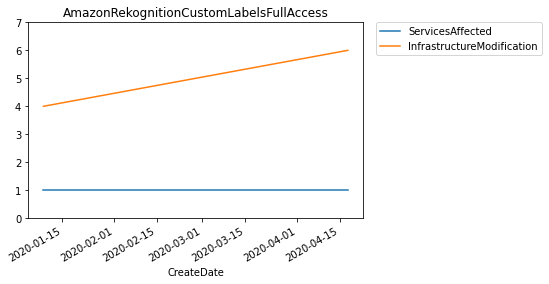

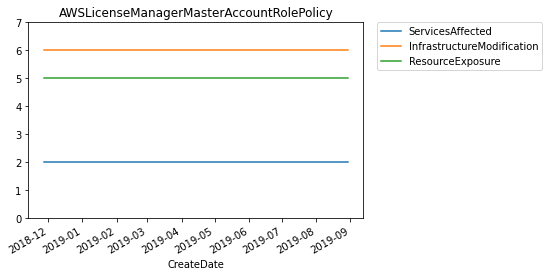

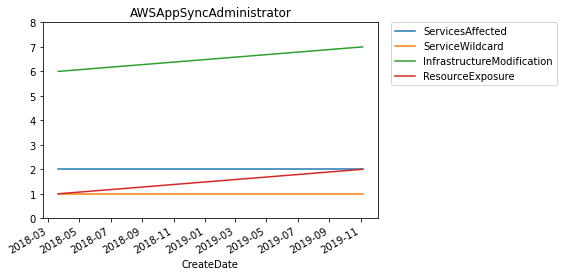

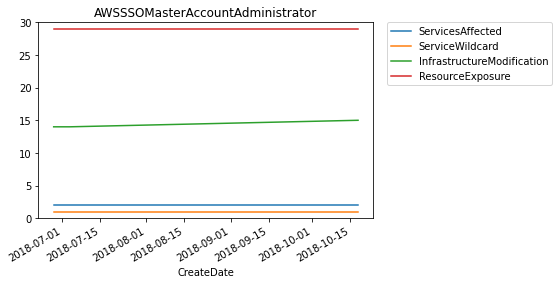

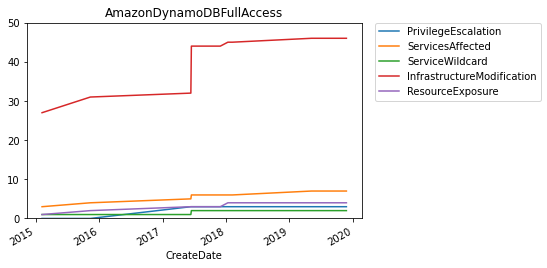

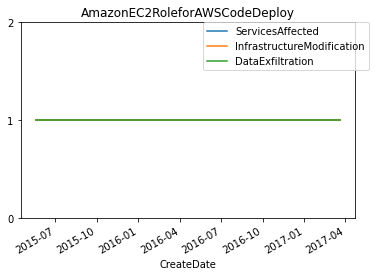

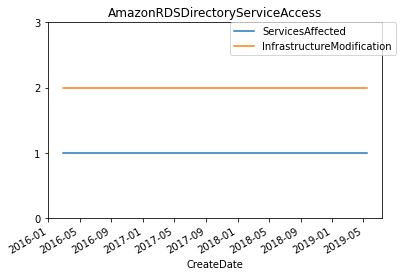

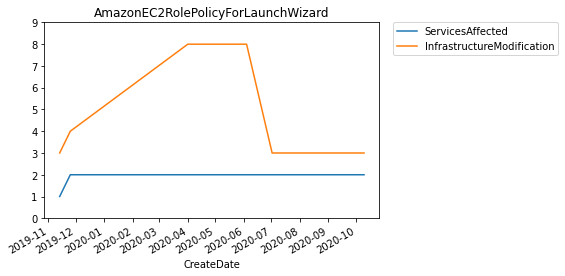

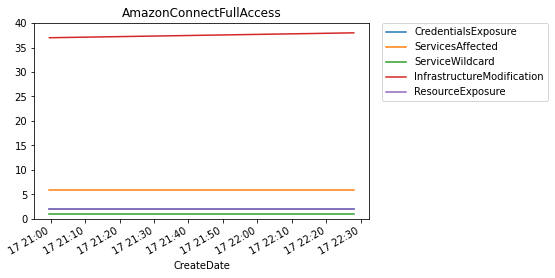

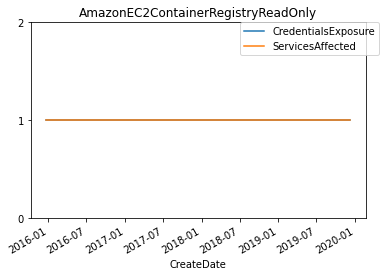

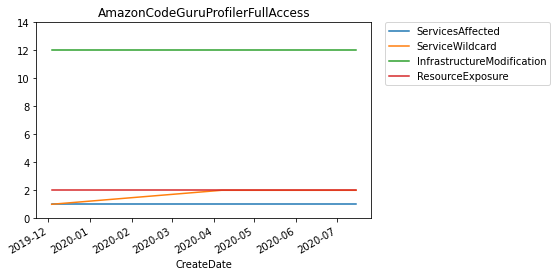

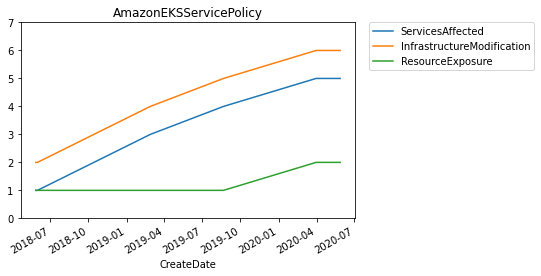

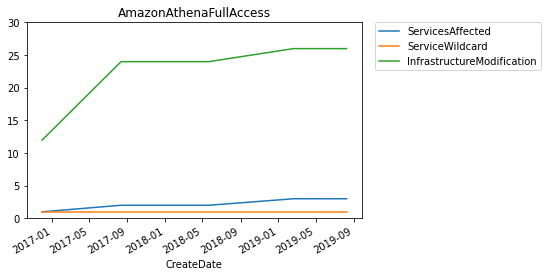

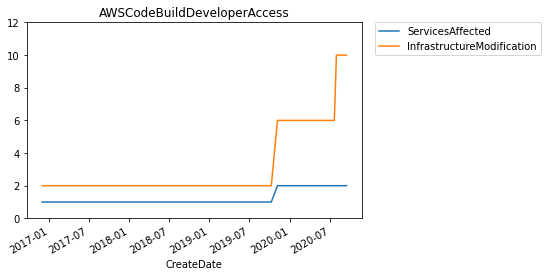

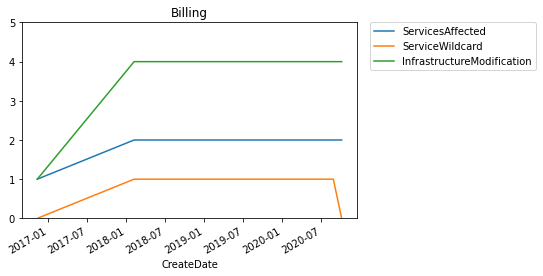

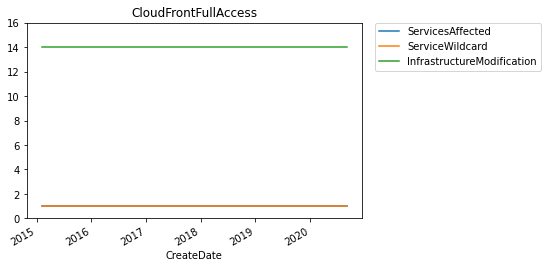

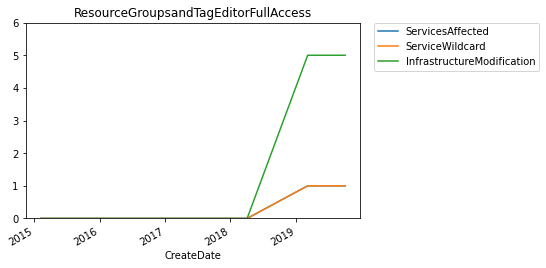

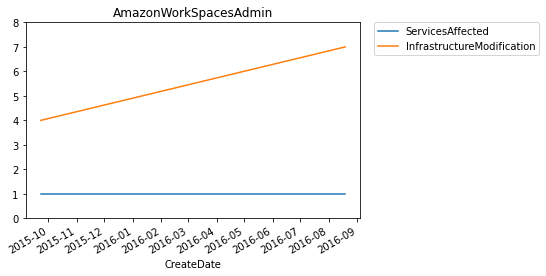

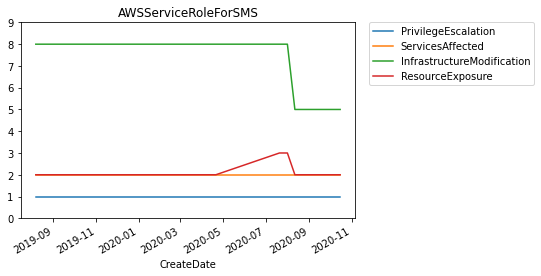

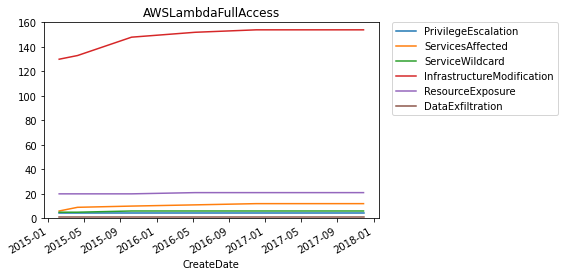

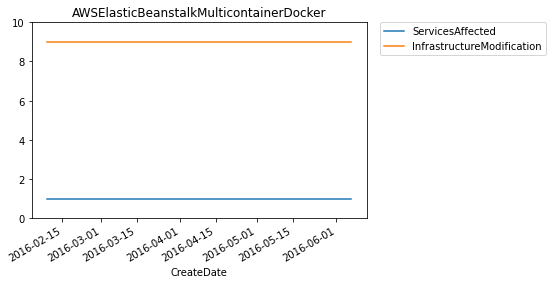

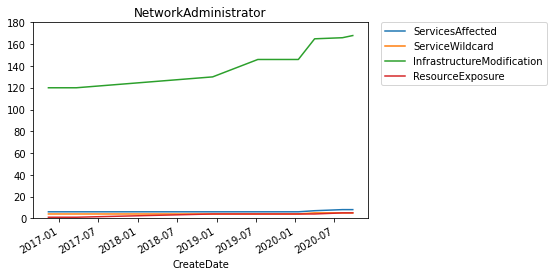

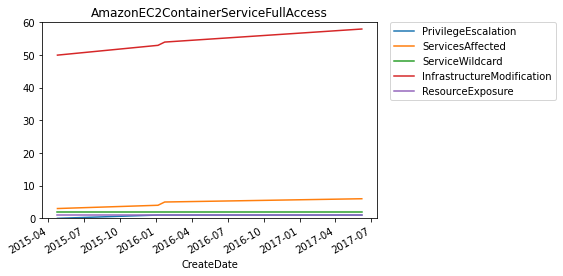

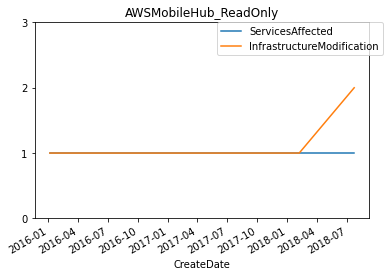

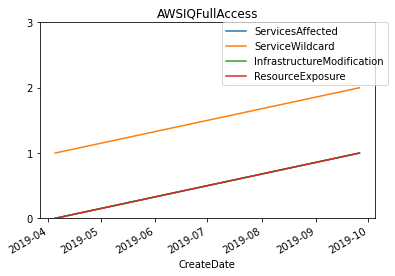

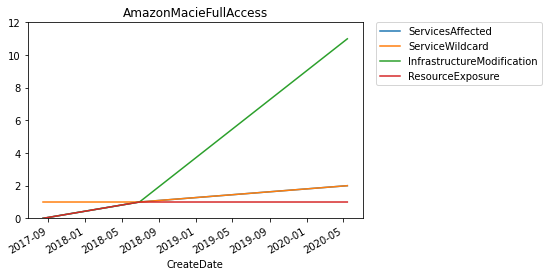

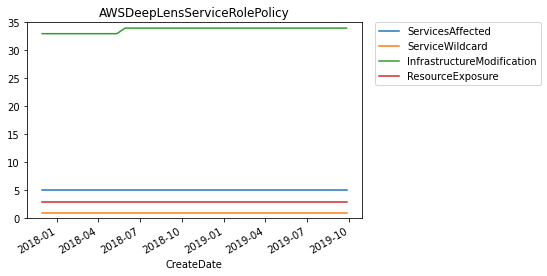

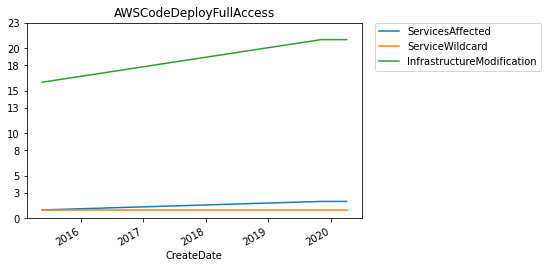

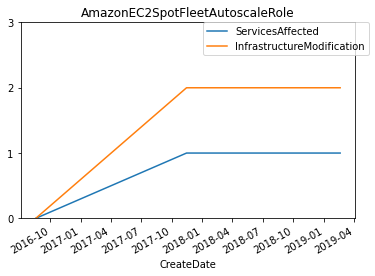

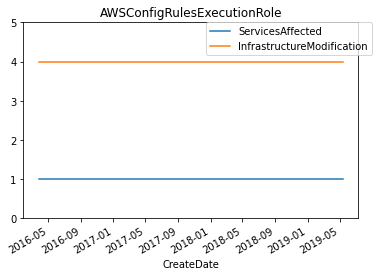

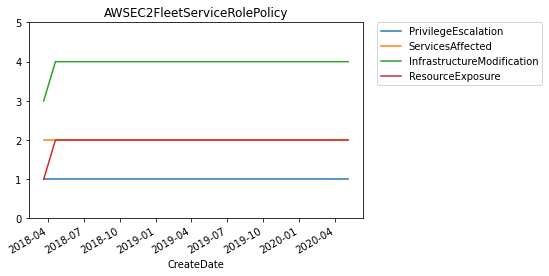

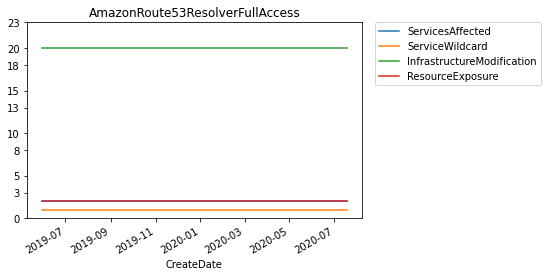

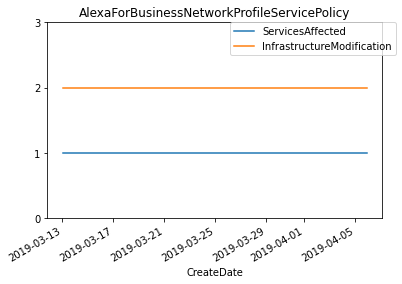

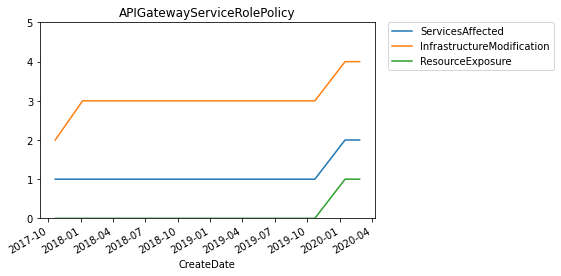

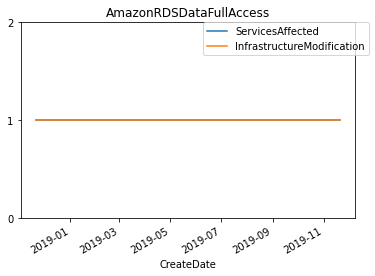

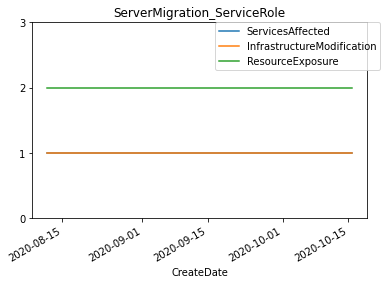

In [40]:
from math import ceil

drop_columns = {'PolicyName', 'IsDefaultVersion'}
non_data_columns = {'CreateDate', 'VersionId'}

for policy in pd['PolicyName'].drop_duplicates():
    # select all version of a single policy
    sub_pd = pd[(pd['PolicyName'] == policy)]

    # drop all-zero and unwanted columns
    cols = set(sub_pd.columns) - drop_columns
    for col in set(sub_pd.columns) - drop_columns - non_data_columns:
        if not (sub_pd[col] > 0).any():
            cols.remove(col)
    sub_pd = sub_pd[list(cols)]

    # skip non-interesting policies
    if sub_pd.shape[0] <= 1 or sub_pd.shape[1] <= 2:
        continue

    # create plot object
    plot = sub_pd.plot(kind='line', title=policy, x='CreateDate')

    # set y axis limit
    max_ytick = 0
    for col in set(sub_pd.columns) - non_data_columns:
        max_ytick = max(max_ytick, max(sub_pd[col]))
    plot.set_ylim(0, max_ytick + 1)

    # ensure only integer ticks
    plot.set_yticks(sorted(set([ceil(x) for x in plot.get_yticks()])))

    # add legend and display
    plot.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

    del cols, sub_pd, max_ytick, plot